In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from random import shuffle

import time
import os

from ops import *
from utils import *

c:\users\eric\anaconda2\envs\hse_dl\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
DATA_PATH = './img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [3]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

Since the link to download the data didn't work I downloaded the data from a different source. The images were the wrong size and I was resizing them as they were loaded, which was painfully slow. Instead we'll try resizing them in advance and hopefully the model will train much faster.

In [4]:
# resize the images since they are the wrong size and shape
import cv2
file_list = os.listdir(DATA_PATH)
RESIZED_DATA_PATH = './celebA_resized2/'

# if the directory exists the images have already been resized and we can skip this step
if not os.path.exists(RESIZED_DATA_PATH):
    os.makedirs(RESIZED_DATA_PATH)
    
    counter = 0
    for f in file_list:
        # read the image in
        original_file_path = os.path.join(DATA_PATH, f)
        img = cv2.imread(original_file_path)
        
        # center crop it so the aspect ratio isn't distorted
        img = crop_center(img, 178, 178)
        
        # size the cropped image down
        img = cv2.resize(img, (64, 64))
        
        # write the image to disk
        cv2.imwrite(os.path.join(RESIZED_DATA_PATH, f), img)
        
        counter += 1
        if counter % 1000 == 0:
            print("%d images have been resized."%counter)     

## Writing generator function (1 point)

In [5]:
## improved version? original seems to work fine, let's keep this in case we need it later
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    # transpose conv 1
    net = deconv2d(h_in, [BATCH_SIZE, 8, 8, 512], name="g_conv_1")
    net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_1")
    net = tf.nn.relu(net)
    
    # tranpose conv 2
    net = deconv2d(net, [BATCH_SIZE, 16, 16, 256], name="g_conv_2")
    net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_2")
    net = tf.nn.relu(net)
    
    # tranpose conv 3
    net = deconv2d(net, [BATCH_SIZE, 32, 32, 128], name="g_conv_3")
    net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_3")
    net = tf.nn.relu(net)
    
    # transpose conv 4
#     net = deconv2d(net, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 16], name='g_conv_4')
#     net = tf.contrib.layers.batch_norm(net, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="g_bn_4")
#     net = tf.nn.relu(net)
    
    # transpose conv with stride 1 to smooth out artifacts as per Odena, et al., 2016
    h_out = tf.layers.conv2d_transpose(
            net,
            filters=N_CHANNELS,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=117932),
            name='g_conv_5'
        )

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [6]:
def discriminator(image, is_training, batch_norms=None):
    # images are cropped and resized in the get_image function rather than in the graph
    
    h0 = conv2d(image, 64, name="d_h0_conv")
    h0 = tf.contrib.layers.batch_norm(h0, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_0")
    h0 = tf.nn.leaky_relu(h0, alpha=0.2, name="d_lrelu_0")
    
    # conv 1 - 64x64x16
    h1 = conv2d(h0, 128, name="d_h1_conv")
    h1 = tf.contrib.layers.batch_norm(h1, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_1.0")
    h1 = tf.nn.leaky_relu(h1, alpha=0.2, name="d_lrelu_1.0")
    
    h2 = conv2d(h1, 256, name="d_h2_conv")
    h2 = tf.contrib.layers.batch_norm(h2, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_2.0")
    h2 = tf.nn.leaky_relu(h2, alpha=0.2, name="d_lrelu_2.0")
    
    h3 = conv2d(h2, 512, name="d_h3_conv")
    h3 = tf.contrib.layers.batch_norm(h3, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_3.0")
    h3 = tf.nn.leaky_relu(h3, alpha=0.2, name="d_lrelu_3.0")
    
    h4 = tf.contrib.layers.flatten(h3)
    
    h4 = tf.layers.dense(
            h4,
            1024,
            activation=None,
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=117),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name="d_fc1"
        )
    h4 = tf.contrib.layers.batch_norm(h4, epsilon=1e-5, center=True, scale=True, is_training=is_training, scope="d_bn_5")
    h4 = tf.nn.relu(h4, name='d_fc1_relu')
    
    linear_out = tf.layers.dense(
            h4,
            1,
            activation=None,
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=118),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name="d_fc2"
        )
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [7]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, 64, 64, N_CHANNELS], name="images_placeholder")
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [8]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake)))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [9]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

# get the batch norm updates so we can run them
gen_extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="G")
dis_extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope="D")

Load data:

In [10]:
data = glob(os.path.join(RESIZED_DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"
print("Data:", len(data))

Data: 112713


Functions for training and evaluations.

In [11]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [ ]:
# make sure the input is properly resized
idx = 0
batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]

print("Image Shape:", batch[0].shape)
plt.imshow(inverse_transform(batch[0]))
plt.show()

In [12]:
def train(sess, load_dir=None, save_frequency=50, sample_frequency=100, sample_dir='sample_faces5',
          save_dir='checkpoint5', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2, 
          print_frequency=25,
          show_samples=True,
          gen_extra_update_ops=gen_extra_update_ops, 
          dis_extra_update_ops=dis_extra_update_ops):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    # shuffle the input data
    shuffle(data)
    
    for epoch in range(17, n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE, resize=False) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
            
            # Update D network
            sess.run([d_optim, dis_extra_update_ops], feed_dict={images: batch_images, z: batch_z, is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run([g_optim, gen_extra_update_ops],
                    feed_dict={z: batch_z, is_training: True})
            
            counter += 1
            # over 100,000 images means a lot of batches and we don't need to see the results for each batch
            # this will also speed up training hopefully
            if np.mod(counter, print_frequency) == 1:
                errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
                errD_real = d_loss_real.eval({images: batch_images, is_training: False})
                errG = g_loss.eval({z: batch_z, is_training: False})

                print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                    epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [8, 8],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.jpg'.format(epoch, idx)))
                print("Sample")
                
                # instead of waiting for the samples to be saved to a file let's display one right here
                if show_samples:
                    print("\n")
                    plt.imshow(inverse_transform(samples[1]))
                    plt.show()
                    print("\n\n\n")

My laptop GPU did not have enough memory to handle training this and it was very slow to train on the CPU, especially when the images were resized at run-time. Due to this the training had to be stopped and started repeatedly and the kernel also crashed several times. 

Hopefully resizing the images in advance will speed the process up.

Epoch: [ 6] [  24/1761] time: 1137.3243, d_loss: 1.38670087, g_loss: 0.67769730
Epoch: [ 6] [  49/1761] time: 1705.2602, d_loss: 1.39607608, g_loss: 0.65727293
Saved model
Epoch: [ 6] [  74/1761] time: 2139.3929, d_loss: 1.39789712, g_loss: 0.61464787
Epoch: [ 6] [  99/1761] time: 2562.7423, d_loss: 1.49686253, g_loss: 0.54015452
Saved model
Sample




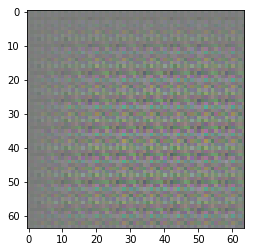





Epoch: [ 6] [ 124/1761] time: 2989.3009, d_loss: 1.38362741, g_loss: 0.56150544
Epoch: [ 6] [ 149/1761] time: 3411.9357, d_loss: 1.47670484, g_loss: 0.46817720
Saved model
Epoch: [ 6] [ 174/1761] time: 3835.5910, d_loss: 1.54896390, g_loss: 0.41276279
Epoch: [ 6] [ 199/1761] time: 4255.6712, d_loss: 1.44539714, g_loss: 0.45220870
Saved model
Sample




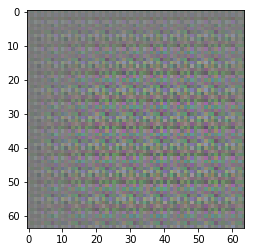





Epoch: [ 6] [ 224/1761] time: 4678.7313, d_loss: 1.21570265, g_loss: 0.74157488
Epoch: [ 6] [ 249/1761] time: 5098.6900, d_loss: 1.36052060, g_loss: 0.51381278
Saved model
Epoch: [ 6] [ 274/1761] time: 5549.2980, d_loss: 1.47868717, g_loss: 0.38927117
Epoch: [ 6] [ 299/1761] time: 5999.8480, d_loss: 1.62480474, g_loss: 0.28825715
Saved model
Sample




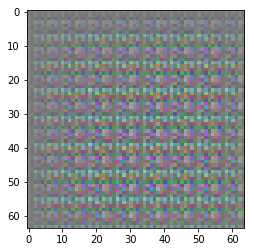





Epoch: [ 6] [ 324/1761] time: 6427.3508, d_loss: 1.76353490, g_loss: 0.40325716
Epoch: [ 6] [ 349/1761] time: 6850.8775, d_loss: 1.00911963, g_loss: 1.28737962
Saved model
Epoch: [ 6] [ 374/1761] time: 7277.5415, d_loss: 1.82663012, g_loss: 0.94662225
Epoch: [ 6] [ 399/1761] time: 7700.1049, d_loss: 4.10177994, g_loss: 3.25424695
Saved model
Sample




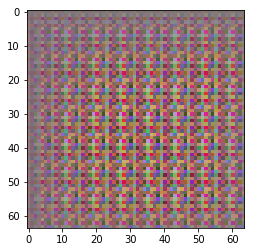





Epoch: [ 6] [ 424/1761] time: 8124.1708, d_loss: 3.60216975, g_loss: 2.72962427
Epoch: [ 6] [ 449/1761] time: 8549.8549, d_loss: 3.31268525, g_loss: 2.98845673
Saved model
Epoch: [ 6] [ 474/1761] time: 8976.3471, d_loss: 2.52753782, g_loss: 1.89058435
Epoch: [ 6] [ 499/1761] time: 9410.9093, d_loss: 2.28692532, g_loss: 1.87842011
Saved model
Sample




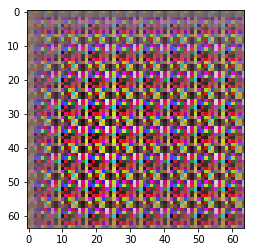





Epoch: [ 6] [ 524/1761] time: 9840.7629, d_loss: 3.28627729, g_loss: 2.81720114
Epoch: [ 6] [ 549/1761] time: 10264.8132, d_loss: 2.05634880, g_loss: 1.25354290
Saved model
Epoch: [ 6] [ 574/1761] time: 10784.8403, d_loss: 2.66575575, g_loss: 1.40225697
Epoch: [ 6] [ 599/1761] time: 11321.7006, d_loss: 2.29450870, g_loss: 1.79238594
Saved model
Sample




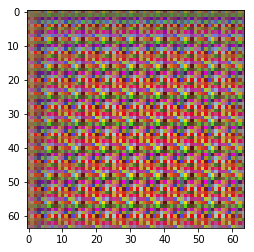





Epoch: [ 6] [ 624/1761] time: 11867.7326, d_loss: 1.85403919, g_loss: 1.22621512
Epoch: [ 6] [ 649/1761] time: 12383.1826, d_loss: 4.22792530, g_loss: 4.62027550
Saved model
Epoch: [ 6] [ 674/1761] time: 12829.1770, d_loss: 2.84495306, g_loss: 2.77649021
Epoch: [ 6] [ 699/1761] time: 13270.3550, d_loss: 3.42463040, g_loss: 3.20355225
Saved model
Sample




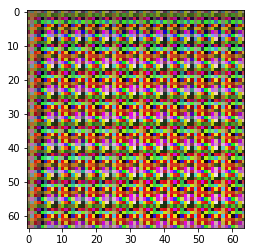





Epoch: [ 6] [ 724/1761] time: 13718.4035, d_loss: 2.58147907, g_loss: 2.11434031
Epoch: [ 6] [ 749/1761] time: 14160.6611, d_loss: 2.40805483, g_loss: 1.06435323
Saved model
Epoch: [ 6] [ 774/1761] time: 14602.5469, d_loss: 1.21051240, g_loss: 1.17435062
Epoch: [ 6] [ 799/1761] time: 15040.4165, d_loss: 4.86733437, g_loss: 0.40885258
Saved model
Sample




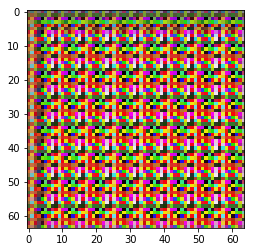





Epoch: [ 6] [ 824/1761] time: 15483.9406, d_loss: 2.30344296, g_loss: 0.31254169
Epoch: [ 6] [ 849/1761] time: 15920.0731, d_loss: 0.73513776, g_loss: 0.87011206
Saved model
Epoch: [ 6] [ 874/1761] time: 16365.9969, d_loss: 1.07224774, g_loss: 0.61394817
Epoch: [ 6] [ 899/1761] time: 16804.2895, d_loss: 3.26084375, g_loss: 0.30693379
Saved model
Sample




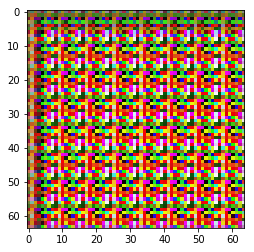





Epoch: [ 6] [ 924/1761] time: 17248.9207, d_loss: 2.22362947, g_loss: 0.30530319
Epoch: [ 6] [ 949/1761] time: 17686.9089, d_loss: 3.75937152, g_loss: 0.24804568
Saved model
Epoch: [ 6] [ 974/1761] time: 18125.4133, d_loss: 1.63220191, g_loss: 0.31969705
Epoch: [ 6] [ 999/1761] time: 18561.3616, d_loss: 1.70817924, g_loss: 0.36193401
Saved model
Sample




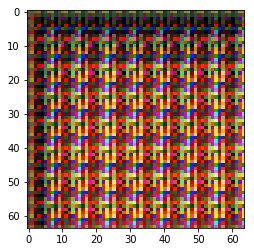





Epoch: [ 6] [1024/1761] time: 19002.1663, d_loss: 2.63111305, g_loss: 0.36104530
Epoch: [ 6] [1049/1761] time: 19438.1033, d_loss: 3.35805559, g_loss: 2.25840473
Saved model
Epoch: [ 6] [1074/1761] time: 19875.6541, d_loss: 2.16522264, g_loss: 0.64082730
Epoch: [ 6] [1099/1761] time: 20308.7246, d_loss: 1.40172553, g_loss: 0.83528090
Saved model
Sample




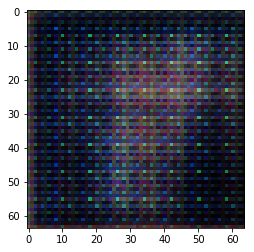





Epoch: [ 6] [1124/1761] time: 20747.3293, d_loss: 2.16608715, g_loss: 0.24797712
Epoch: [ 6] [1149/1761] time: 21181.5429, d_loss: 1.94359040, g_loss: 0.26286077
Saved model
Epoch: [ 6] [1174/1761] time: 21618.5320, d_loss: 2.70883369, g_loss: 0.09814736
Epoch: [ 6] [1199/1761] time: 22053.5492, d_loss: 3.94068599, g_loss: 0.02862293
Saved model
Sample




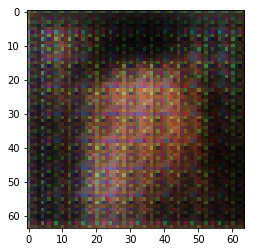





Epoch: [ 6] [1224/1761] time: 22491.7701, d_loss: 3.48533511, g_loss: 0.05686874
Epoch: [ 6] [1249/1761] time: 22926.5882, d_loss: 3.78333426, g_loss: 0.07389776
Saved model
Epoch: [ 6] [1274/1761] time: 23363.5429, d_loss: 3.56226587, g_loss: 0.04023502
Epoch: [ 6] [1299/1761] time: 23797.7147, d_loss: 3.01823974, g_loss: 0.07026529
Saved model
Sample




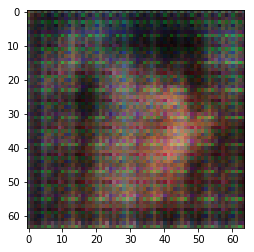





Epoch: [ 6] [1324/1761] time: 24236.3828, d_loss: 2.47967529, g_loss: 0.14249973
Epoch: [ 6] [1349/1761] time: 24669.3877, d_loss: 2.15409088, g_loss: 0.18768314
Saved model
Epoch: [ 6] [1374/1761] time: 25107.2154, d_loss: 2.14801097, g_loss: 0.19281998
Epoch: [ 6] [1399/1761] time: 25542.3850, d_loss: 1.52982807, g_loss: 0.35805833
Saved model
Sample




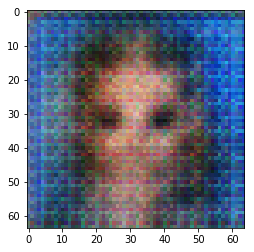





Epoch: [ 6] [1424/1761] time: 25980.2761, d_loss: 1.36557627, g_loss: 0.47195256
Epoch: [ 6] [1449/1761] time: 26413.5094, d_loss: 1.53953981, g_loss: 1.16214979
Saved model
Epoch: [ 6] [1474/1761] time: 37647.1006, d_loss: 1.25198269, g_loss: 1.11905384
Epoch: [ 6] [1499/1761] time: 58151.4637, d_loss: 1.66517925, g_loss: 0.36808136
Saved model
Sample




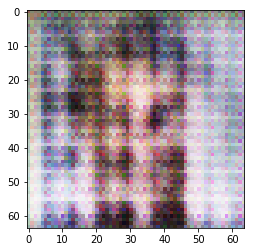





Epoch: [ 6] [1524/1761] time: 58592.6023, d_loss: 1.48476994, g_loss: 0.41889358
Epoch: [ 6] [1549/1761] time: 59015.4724, d_loss: 1.40731180, g_loss: 0.49279690
Saved model
Epoch: [ 6] [1574/1761] time: 59438.6435, d_loss: 1.37357450, g_loss: 0.78965187
Epoch: [ 6] [1599/1761] time: 59860.6988, d_loss: 1.39732134, g_loss: 0.53443581
Saved model
Sample




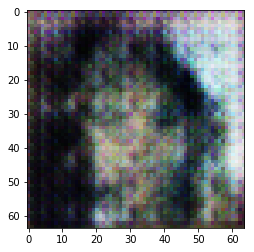





Epoch: [ 6] [1624/1761] time: 60286.8436, d_loss: 1.58886838, g_loss: 0.47627643
Epoch: [ 6] [1649/1761] time: 60718.5175, d_loss: 1.63849902, g_loss: 0.30612338
Saved model
Epoch: [ 6] [1674/1761] time: 61152.1226, d_loss: 1.60963106, g_loss: 0.33645090
Epoch: [ 6] [1699/1761] time: 61594.1858, d_loss: 1.45506251, g_loss: 0.60842478
Saved model
Sample




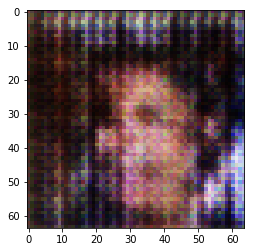





Epoch: [ 6] [1724/1761] time: 62030.9201, d_loss: 1.44985855, g_loss: 0.49066207
Epoch: [ 6] [1749/1761] time: 62463.5770, d_loss: 1.43335986, g_loss: 0.76507229
Saved model
Epoch: [ 7] [  13/1761] time: 62890.8309, d_loss: 1.47452950, g_loss: 0.88562429
Epoch: [ 7] [  38/1761] time: 63313.8282, d_loss: 1.42882431, g_loss: 0.52176368
Saved model
Sample




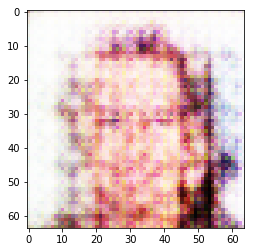





Epoch: [ 7] [  63/1761] time: 63739.7881, d_loss: 1.40352595, g_loss: 0.83245111
Epoch: [ 7] [  88/1761] time: 64162.9288, d_loss: 1.37564206, g_loss: 0.78349924
Saved model
Epoch: [ 7] [ 113/1761] time: 64593.0202, d_loss: 1.57347775, g_loss: 0.38185769
Epoch: [ 7] [ 138/1761] time: 65026.2637, d_loss: 1.25690651, g_loss: 0.72310811
Saved model
Sample




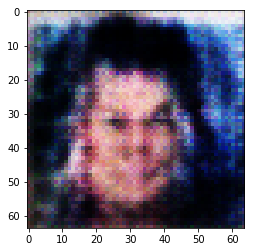





Epoch: [ 7] [ 163/1761] time: 65459.4550, d_loss: 1.67917943, g_loss: 1.39854908
Epoch: [ 7] [ 188/1761] time: 65882.8215, d_loss: 1.41536474, g_loss: 0.58731961
Saved model
Epoch: [ 7] [ 213/1761] time: 66308.0570, d_loss: 1.38800800, g_loss: 0.86200833
Epoch: [ 7] [ 238/1761] time: 66731.9065, d_loss: 1.40422106, g_loss: 0.62085927
Saved model
Sample




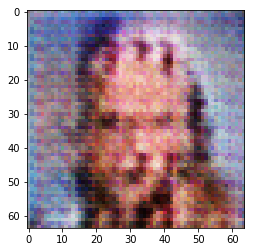





Epoch: [ 7] [ 263/1761] time: 67171.5586, d_loss: 1.46870279, g_loss: 0.63390660
Epoch: [ 7] [ 288/1761] time: 67607.3894, d_loss: 1.36611438, g_loss: 0.58300042
Saved model
Epoch: [ 7] [ 313/1761] time: 68035.7261, d_loss: 1.38659084, g_loss: 0.57329905
Epoch: [ 7] [ 338/1761] time: 68459.1413, d_loss: 1.42702484, g_loss: 0.48914117
Saved model
Sample




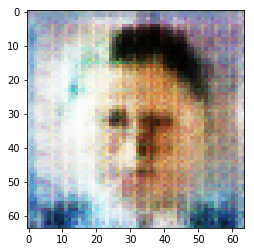





Epoch: [ 7] [ 363/1761] time: 68887.2234, d_loss: 1.64810717, g_loss: 0.31769520
Epoch: [ 7] [ 388/1761] time: 69313.8424, d_loss: 1.36885977, g_loss: 0.65972900
Saved model
Epoch: [ 7] [ 413/1761] time: 69749.0130, d_loss: 1.33016324, g_loss: 0.52618778
Epoch: [ 7] [ 438/1761] time: 70181.3354, d_loss: 1.60642278, g_loss: 0.38699439
Saved model
Sample




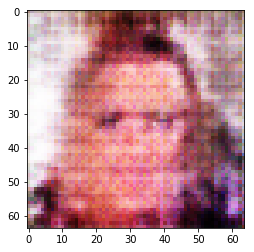





Epoch: [ 7] [ 463/1761] time: 70618.3622, d_loss: 1.31034398, g_loss: 0.69151533
Epoch: [ 7] [ 488/1761] time: 71051.3356, d_loss: 1.34548283, g_loss: 0.59297955
Saved model
Epoch: [ 7] [ 513/1761] time: 71485.7837, d_loss: 1.65014958, g_loss: 0.35636073
Epoch: [ 7] [ 538/1761] time: 71918.0350, d_loss: 1.54541337, g_loss: 0.40177035
Saved model
Sample




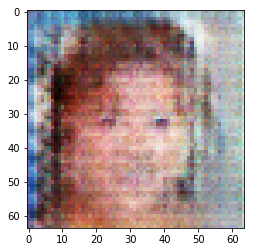





Epoch: [ 7] [ 563/1761] time: 72355.7519, d_loss: 1.52368319, g_loss: 0.40831774
Epoch: [ 7] [ 588/1761] time: 72788.8497, d_loss: 1.70497286, g_loss: 0.34514388
Saved model
Epoch: [ 7] [ 613/1761] time: 73224.3039, d_loss: 1.77875936, g_loss: 0.30282354
Epoch: [ 7] [ 638/1761] time: 73656.0597, d_loss: 1.46431804, g_loss: 0.74915779
Saved model
Sample




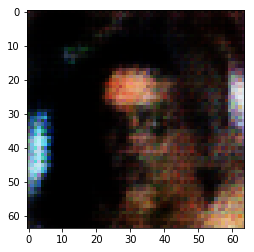





Epoch: [ 7] [ 663/1761] time: 74093.0052, d_loss: 1.35767758, g_loss: 0.68854165
Epoch: [ 7] [ 688/1761] time: 74524.5084, d_loss: 1.44382358, g_loss: 0.62724650
Saved model
Epoch: [ 7] [ 713/1761] time: 74959.4057, d_loss: 1.34246111, g_loss: 0.56046212
Epoch: [ 7] [ 738/1761] time: 75392.2218, d_loss: 1.26877439, g_loss: 0.68064964
Saved model
Sample




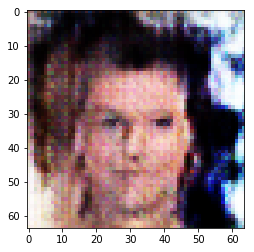





Epoch: [ 7] [ 763/1761] time: 75833.8889, d_loss: 1.36848545, g_loss: 0.54529673
Epoch: [ 7] [ 788/1761] time: 76265.4924, d_loss: 1.49234986, g_loss: 0.45615628
Saved model
Epoch: [ 7] [ 813/1761] time: 76702.1941, d_loss: 1.35601604, g_loss: 0.79012990
Epoch: [ 7] [ 838/1761] time: 77134.5668, d_loss: 1.39375937, g_loss: 1.00808990
Saved model
Sample




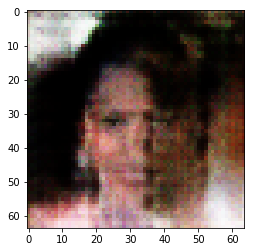





Epoch: [ 7] [ 863/1761] time: 77572.0002, d_loss: 1.44264698, g_loss: 0.91627812
Epoch: [ 7] [ 888/1761] time: 78004.2114, d_loss: 1.29324722, g_loss: 0.69113743
Saved model
Epoch: [ 7] [ 913/1761] time: 82905.0714, d_loss: 1.38093209, g_loss: 0.78782296
Epoch: [ 7] [ 938/1761] time: 83331.5077, d_loss: 1.60852957, g_loss: 0.35522878
Saved model
Sample




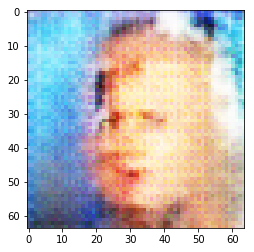





Epoch: [ 7] [ 963/1761] time: 83757.4946, d_loss: 1.48311639, g_loss: 0.47373745
Epoch: [ 7] [ 988/1761] time: 84179.4674, d_loss: 1.30438364, g_loss: 0.84598070
Saved model
Epoch: [ 7] [1013/1761] time: 84603.2063, d_loss: 1.34846473, g_loss: 0.98722374
Epoch: [ 7] [1038/1761] time: 85024.6221, d_loss: 1.35539865, g_loss: 0.64202499
Saved model
Sample




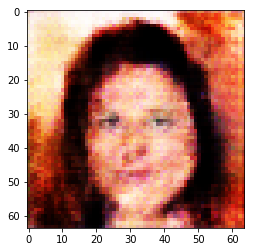





Epoch: [ 7] [1063/1761] time: 85448.0291, d_loss: 1.52671623, g_loss: 0.48955289
Epoch: [ 7] [1088/1761] time: 85870.4750, d_loss: 1.34230804, g_loss: 0.95540893
Saved model
Epoch: [ 7] [1113/1761] time: 86298.6959, d_loss: 1.29789972, g_loss: 0.92851102
Epoch: [ 7] [1138/1761] time: 86723.8531, d_loss: 1.39795196, g_loss: 0.65856910
Saved model
Sample




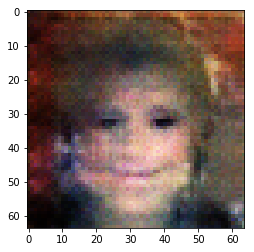





Epoch: [ 7] [1163/1761] time: 87151.4388, d_loss: 1.56291425, g_loss: 0.90878338
Epoch: [ 7] [1188/1761] time: 87573.8976, d_loss: 1.81858695, g_loss: 1.06284738
Saved model
Epoch: [ 7] [1213/1761] time: 87996.6152, d_loss: 1.58928108, g_loss: 1.27622843
Epoch: [ 7] [1238/1761] time: 88416.6096, d_loss: 1.50067759, g_loss: 0.88335407
Saved model
Sample




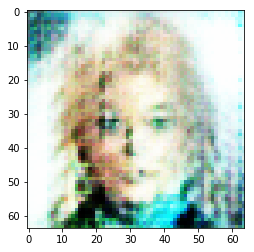





Epoch: [ 7] [1263/1761] time: 88840.8761, d_loss: 1.34431767, g_loss: 1.39324141
Epoch: [ 7] [1288/1761] time: 89260.6614, d_loss: 1.31602693, g_loss: 1.52265501
Saved model
Epoch: [ 7] [1313/1761] time: 89716.6262, d_loss: 1.63189554, g_loss: 1.73744845
Epoch: [ 7] [1338/1761] time: 90179.2564, d_loss: 1.51435077, g_loss: 0.85019720
Saved model
Sample




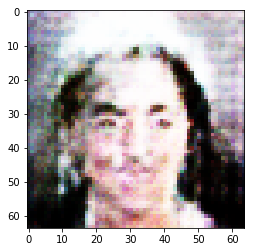





Epoch: [ 7] [1363/1761] time: 90653.7988, d_loss: 1.81272674, g_loss: 0.95444083
Epoch: [ 7] [1388/1761] time: 91143.4209, d_loss: 1.68214035, g_loss: 0.85475814
Saved model
Epoch: [ 7] [1413/1761] time: 91631.1886, d_loss: 1.69713902, g_loss: 1.24085474
Epoch: [ 7] [1438/1761] time: 92108.3992, d_loss: 1.56403017, g_loss: 0.89959842
Saved model
Sample




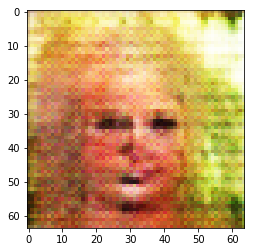





Epoch: [ 7] [1463/1761] time: 92617.6146, d_loss: 1.45621014, g_loss: 1.27478027
Epoch: [ 7] [1488/1761] time: 93106.9400, d_loss: 1.76543224, g_loss: 1.11003089
Saved model
Epoch: [ 7] [1513/1761] time: 93590.4042, d_loss: 1.35277486, g_loss: 1.75290310
Epoch: [ 7] [1538/1761] time: 94048.7137, d_loss: 1.52279055, g_loss: 0.64265037
Saved model
Sample




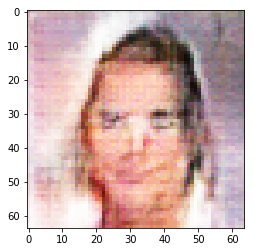





Epoch: [ 7] [1563/1761] time: 94491.1860, d_loss: 1.57174826, g_loss: 1.19677055
Epoch: [ 7] [1588/1761] time: 94914.8159, d_loss: 1.43009639, g_loss: 0.64186889
Saved model
Epoch: [ 7] [1613/1761] time: 95349.1673, d_loss: 1.56044459, g_loss: 0.47967175
Epoch: [ 7] [1638/1761] time: 95773.8435, d_loss: 1.30722880, g_loss: 0.66790617
Saved model
Sample




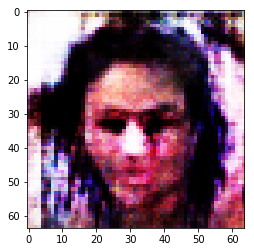





Epoch: [ 7] [1663/1761] time: 96202.5308, d_loss: 1.20688772, g_loss: 0.80468333
Epoch: [ 7] [1688/1761] time: 96625.7903, d_loss: 1.54140985, g_loss: 0.60768414
Saved model
Epoch: [ 7] [1713/1761] time: 97052.4988, d_loss: 1.44082999, g_loss: 0.60974145
Epoch: [ 7] [1738/1761] time: 97474.2104, d_loss: 1.33726895, g_loss: 0.76168162
Saved model
Sample




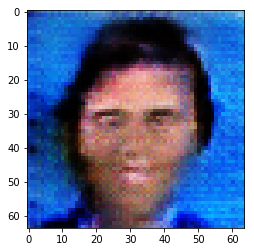





Epoch: [ 8] [   2/1761] time: 97903.1081, d_loss: 1.35305023, g_loss: 0.56806135
Epoch: [ 8] [  27/1761] time: 98326.2169, d_loss: 1.72376513, g_loss: 0.47533166
Saved model
Epoch: [ 8] [  52/1761] time: 98750.1612, d_loss: 2.10889697, g_loss: 0.54329848
Epoch: [ 8] [  77/1761] time: 99172.0636, d_loss: 1.39288628, g_loss: 0.65139258
Saved model
Sample




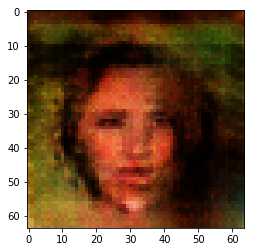





Epoch: [ 8] [ 102/1761] time: 99597.9751, d_loss: 1.46314704, g_loss: 0.49657696
Epoch: [ 8] [ 127/1761] time: 100018.9191, d_loss: 1.19264960, g_loss: 0.99969918
Saved model
Epoch: [ 8] [ 152/1761] time: 100445.6078, d_loss: 1.29274297, g_loss: 0.91481453
Epoch: [ 8] [ 177/1761] time: 100867.7862, d_loss: 1.38166916, g_loss: 0.83663392
Saved model
Sample




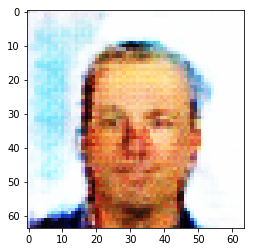





Epoch: [ 8] [ 202/1761] time: 101295.5775, d_loss: 1.50988996, g_loss: 0.48178220
Epoch: [ 8] [ 227/1761] time: 101716.2639, d_loss: 1.38756895, g_loss: 0.72508550
Saved model
Epoch: [ 8] [ 252/1761] time: 102140.1134, d_loss: 1.47097158, g_loss: 0.81385934
Epoch: [ 8] [ 277/1761] time: 102560.6881, d_loss: 1.49720502, g_loss: 0.46446884
Saved model
Sample




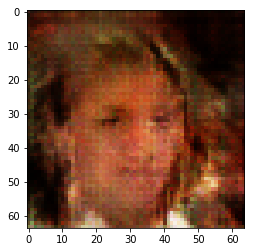





Epoch: [ 8] [ 302/1761] time: 102984.0449, d_loss: 1.28821278, g_loss: 0.60340643
Epoch: [ 8] [ 327/1761] time: 103400.8618, d_loss: 1.39941537, g_loss: 0.74284470
Saved model
Epoch: [ 8] [ 352/1761] time: 103821.0601, d_loss: 1.57057321, g_loss: 0.65636128
Epoch: [ 8] [ 377/1761] time: 104238.6378, d_loss: 1.70888507, g_loss: 0.46902227
Saved model
Sample




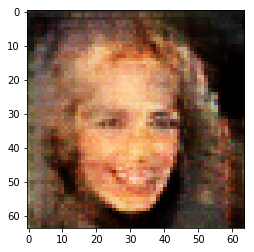





Epoch: [ 8] [ 402/1761] time: 104662.6486, d_loss: 1.39014375, g_loss: 0.62678444
Epoch: [ 8] [ 427/1761] time: 105080.7727, d_loss: 1.48877466, g_loss: 0.54656708
Saved model
Epoch: [ 8] [ 452/1761] time: 105501.6284, d_loss: 1.43372059, g_loss: 0.61408055
Epoch: [ 8] [ 477/1761] time: 105919.8368, d_loss: 1.41906214, g_loss: 0.68048990
Saved model
Sample




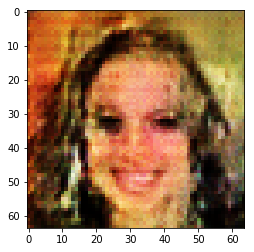





Epoch: [ 8] [ 502/1761] time: 106342.1612, d_loss: 1.58079994, g_loss: 0.57842934
Epoch: [ 8] [ 527/1761] time: 106760.1297, d_loss: 1.47784066, g_loss: 0.49188802
Saved model
Epoch: [ 8] [ 552/1761] time: 107180.3812, d_loss: 1.45740294, g_loss: 0.54900813
Epoch: [ 8] [ 577/1761] time: 107597.4978, d_loss: 1.62973475, g_loss: 0.91770136
Saved model
Sample




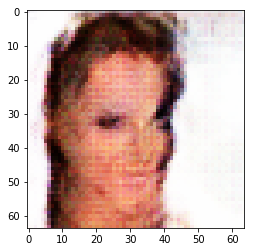





Epoch: [ 8] [ 602/1761] time: 108019.8726, d_loss: 1.37894332, g_loss: 0.59037483
Epoch: [ 8] [ 627/1761] time: 108437.2564, d_loss: 1.45420671, g_loss: 0.72692096
Saved model
Epoch: [ 8] [ 652/1761] time: 108858.7536, d_loss: 1.39963925, g_loss: 0.71460491
Epoch: [ 8] [ 677/1761] time: 109275.7500, d_loss: 1.62158859, g_loss: 0.43522465
Saved model
Sample




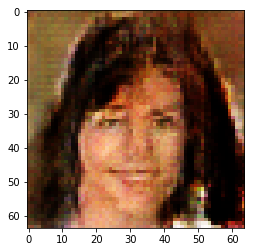





Epoch: [ 8] [ 702/1761] time: 109697.5360, d_loss: 1.42708588, g_loss: 0.63172507
Epoch: [ 8] [ 727/1761] time: 110114.3925, d_loss: 1.45058715, g_loss: 0.70567495
Saved model
Epoch: [ 8] [ 752/1761] time: 110534.7880, d_loss: 1.48662686, g_loss: 0.68021965
Epoch: [ 8] [ 777/1761] time: 110952.0046, d_loss: 1.26712823, g_loss: 0.69233084
Saved model
Sample




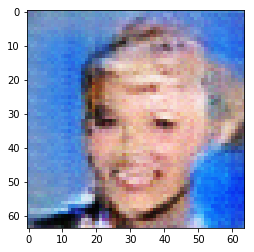





Epoch: [ 8] [ 802/1761] time: 111373.5817, d_loss: 1.95036912, g_loss: 0.39005592
Epoch: [ 8] [ 827/1761] time: 143430.7621, d_loss: 2.40991735, g_loss: 0.19556245
Saved model
Epoch: [ 8] [ 852/1761] time: 143881.3759, d_loss: 1.48102546, g_loss: 0.49214518
Epoch: [ 8] [ 877/1761] time: 144307.7075, d_loss: 1.45624161, g_loss: 0.84201753
Saved model
Sample




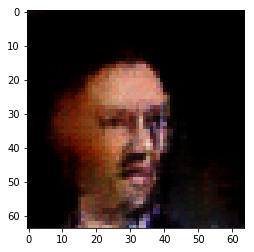





Epoch: [ 8] [ 902/1761] time: 144732.4670, d_loss: 1.50082111, g_loss: 0.51564860
Epoch: [ 8] [ 927/1761] time: 145154.7937, d_loss: 1.54160261, g_loss: 0.63896430
Saved model
Epoch: [ 8] [ 952/1761] time: 145578.8148, d_loss: 1.44676781, g_loss: 0.62293124
Epoch: [ 8] [ 977/1761] time: 146001.8417, d_loss: 1.28293383, g_loss: 0.80488598
Saved model
Sample




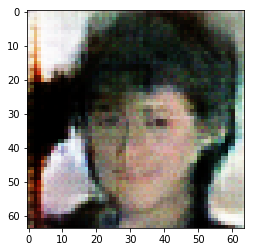





Epoch: [ 8] [1002/1761] time: 146434.8621, d_loss: 1.64893389, g_loss: 0.55284852
Epoch: [ 8] [1027/1761] time: 146865.8774, d_loss: 1.37671614, g_loss: 0.56373376
Saved model
Epoch: [ 8] [1052/1761] time: 147307.6005, d_loss: 1.20736098, g_loss: 0.84775555
Epoch: [ 8] [1077/1761] time: 147738.8554, d_loss: 1.54096377, g_loss: 0.87059164
Saved model
Sample




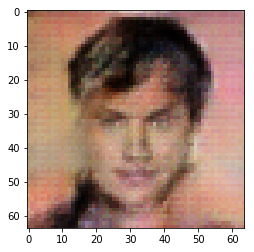





Epoch: [ 8] [1102/1761] time: 148172.8618, d_loss: 1.21332395, g_loss: 1.11328852
Epoch: [ 8] [1127/1761] time: 148603.0080, d_loss: 1.34303284, g_loss: 0.76296568
Saved model
Epoch: [ 8] [1152/1761] time: 149037.4393, d_loss: 1.48596811, g_loss: 0.54606932
Epoch: [ 8] [1177/1761] time: 149459.8801, d_loss: 1.60092688, g_loss: 0.34883726
Saved model
Sample




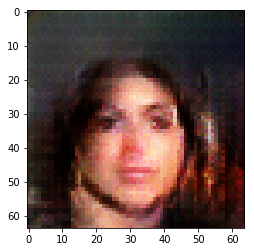





Epoch: [ 8] [1202/1761] time: 149885.1166, d_loss: 1.44227576, g_loss: 0.49467680
Epoch: [ 8] [1227/1761] time: 150306.4131, d_loss: 1.34899104, g_loss: 0.86862469
Saved model
Epoch: [ 8] [1252/1761] time: 150732.1377, d_loss: 1.56055319, g_loss: 0.71839952
Epoch: [ 8] [1277/1761] time: 151163.3413, d_loss: 1.53339863, g_loss: 0.57746196
Saved model
Sample




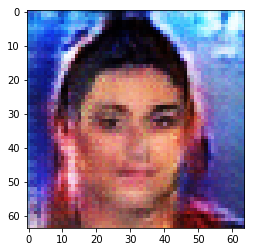





Epoch: [ 8] [1302/1761] time: 151610.8421, d_loss: 1.35280371, g_loss: 0.49709052
Epoch: [ 8] [1327/1761] time: 152077.6043, d_loss: 1.25526142, g_loss: 0.70535296
Saved model
Epoch: [ 8] [1352/1761] time: 152550.7781, d_loss: 1.36290407, g_loss: 0.72711027
Epoch: [ 8] [1377/1761] time: 153026.6694, d_loss: 1.47657418, g_loss: 0.61115837
Saved model
Sample




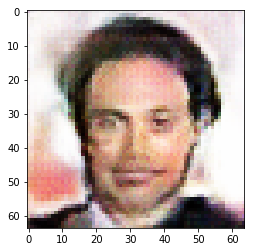





Epoch: [ 8] [1402/1761] time: 153530.2400, d_loss: 1.31589055, g_loss: 0.93894255
Epoch: [ 8] [1427/1761] time: 154005.9724, d_loss: 1.43227386, g_loss: 0.87880039
Saved model
Epoch: [ 8] [1452/1761] time: 154507.1310, d_loss: 1.21385038, g_loss: 0.92825574
Epoch: [ 8] [1477/1761] time: 155001.0715, d_loss: 1.56280613, g_loss: 1.14357531
Saved model
Sample




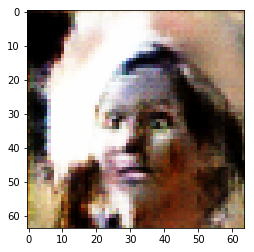





Epoch: [ 8] [1502/1761] time: 155504.8248, d_loss: 1.42461967, g_loss: 0.68137300
Epoch: [ 8] [1527/1761] time: 156012.3808, d_loss: 1.26291990, g_loss: 0.85853958
Saved model
Epoch: [ 8] [1552/1761] time: 156520.0466, d_loss: 1.38142622, g_loss: 0.70628273
Epoch: [ 8] [1577/1761] time: 157000.3615, d_loss: 1.47235668, g_loss: 1.04048872
Saved model
Sample




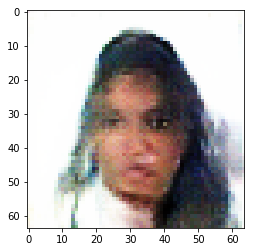





Epoch: [ 8] [1602/1761] time: 157470.7121, d_loss: 1.55805182, g_loss: 0.40556619
Epoch: [ 8] [1627/1761] time: 157931.3337, d_loss: 1.43709064, g_loss: 0.66346824
Saved model
Epoch: [ 8] [1652/1761] time: 158386.5218, d_loss: 1.42984354, g_loss: 0.50812745
Epoch: [ 8] [1677/1761] time: 158847.5402, d_loss: 1.42154169, g_loss: 0.69229543
Saved model
Sample




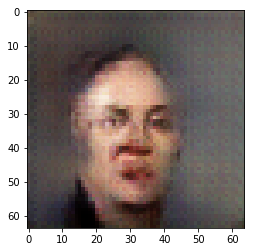





Epoch: [ 8] [1702/1761] time: 159316.8062, d_loss: 1.27696323, g_loss: 0.68635559
Epoch: [ 8] [1727/1761] time: 159791.8815, d_loss: 1.68322659, g_loss: 0.34767139
Saved model
Epoch: [ 8] [1752/1761] time: 160287.1120, d_loss: 1.40435684, g_loss: 0.49995571
Epoch: [ 9] [  16/1761] time: 160731.5738, d_loss: 1.48563337, g_loss: 0.49291539
Saved model
Sample




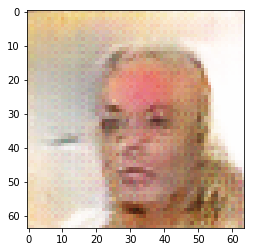





Epoch: [ 9] [  41/1761] time: 161178.4321, d_loss: 2.05575895, g_loss: 0.24375796
Epoch: [ 9] [  66/1761] time: 161609.8093, d_loss: 1.33692575, g_loss: 0.54568636
Saved model
Epoch: [ 9] [  91/1761] time: 162061.1215, d_loss: 1.52133656, g_loss: 0.49749035
Epoch: [ 9] [ 116/1761] time: 162540.9321, d_loss: 1.42708707, g_loss: 0.47784203
Saved model
Sample




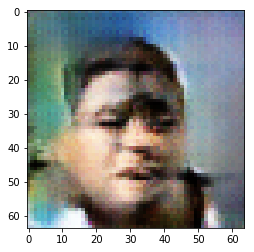





Epoch: [ 9] [ 141/1761] time: 163005.7093, d_loss: 1.68322778, g_loss: 0.34685630
Epoch: [ 9] [ 166/1761] time: 163449.4267, d_loss: 1.57708120, g_loss: 0.36373883
Saved model
Epoch: [ 9] [ 191/1761] time: 163950.9415, d_loss: 1.22291279, g_loss: 0.62474251
Epoch: [ 9] [ 216/1761] time: 164436.7502, d_loss: 1.32462871, g_loss: 0.88249254
Saved model
Sample




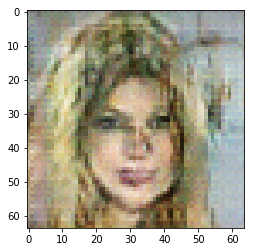





Epoch: [ 9] [ 241/1761] time: 164882.7732, d_loss: 1.60493875, g_loss: 0.36881453
Epoch: [ 9] [ 266/1761] time: 165325.5238, d_loss: 1.63359725, g_loss: 0.48110723
Saved model
Epoch: [ 9] [ 291/1761] time: 165768.6887, d_loss: 1.40080380, g_loss: 0.56595200
Epoch: [ 9] [ 316/1761] time: 166226.4215, d_loss: 1.29884064, g_loss: 0.55233681
Saved model
Sample




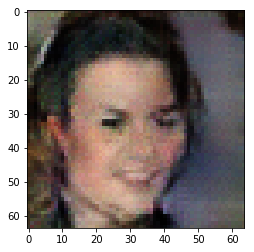





Epoch: [ 9] [ 341/1761] time: 166687.1492, d_loss: 1.24720228, g_loss: 0.61636555
Epoch: [ 9] [ 366/1761] time: 167151.1342, d_loss: 1.48337674, g_loss: 0.48776764
Saved model
Epoch: [ 9] [ 391/1761] time: 167611.7974, d_loss: 1.70358479, g_loss: 0.29586810
Epoch: [ 9] [ 416/1761] time: 168064.1600, d_loss: 1.60112762, g_loss: 0.34238178
Saved model
Sample




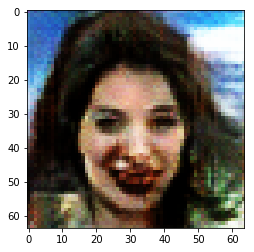





Epoch: [ 9] [ 441/1761] time: 168555.6079, d_loss: 1.31051159, g_loss: 0.85496837
Epoch: [ 9] [ 466/1761] time: 168981.2031, d_loss: 1.36848330, g_loss: 0.56129241
Saved model
Epoch: [ 9] [ 491/1761] time: 169408.3864, d_loss: 1.50769246, g_loss: 0.56980342
Epoch: [ 9] [ 516/1761] time: 169844.2287, d_loss: 1.59892869, g_loss: 0.45515528
Saved model
Sample




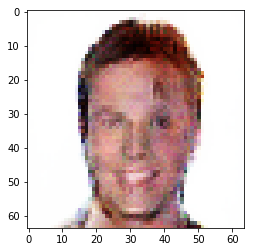





Epoch: [ 9] [ 541/1761] time: 170312.3657, d_loss: 1.35230780, g_loss: 0.73008800
Epoch: [ 9] [ 566/1761] time: 170773.2162, d_loss: 1.47995508, g_loss: 0.46087939
Saved model
Epoch: [ 9] [ 591/1761] time: 171239.4880, d_loss: 1.34979403, g_loss: 0.62238628
Epoch: [ 9] [ 616/1761] time: 171712.2141, d_loss: 1.37655520, g_loss: 0.57535338
Saved model
Sample




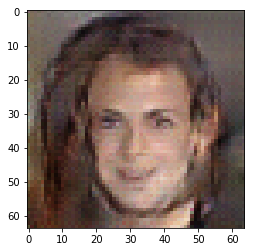





Epoch: [ 9] [ 641/1761] time: 172181.0776, d_loss: 1.28313243, g_loss: 0.69030333
Epoch: [ 9] [ 666/1761] time: 172653.4408, d_loss: 1.38581920, g_loss: 1.23705339
Saved model
Epoch: [ 9] [ 691/1761] time: 173103.1914, d_loss: 1.44075215, g_loss: 0.43664068
Epoch: [ 9] [ 716/1761] time: 173539.0183, d_loss: 1.27701771, g_loss: 0.93186504
Saved model
Sample




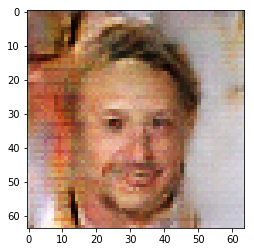





Epoch: [ 9] [ 741/1761] time: 173970.3515, d_loss: 1.35573304, g_loss: 0.69165415
Epoch: [ 9] [ 766/1761] time: 174405.6447, d_loss: 1.43384099, g_loss: 0.64834523
Saved model
Epoch: [ 9] [ 791/1761] time: 174842.5722, d_loss: 1.46366096, g_loss: 0.47795856
Epoch: [ 9] [ 816/1761] time: 175271.7250, d_loss: 1.64577079, g_loss: 0.34161398
Saved model
Sample




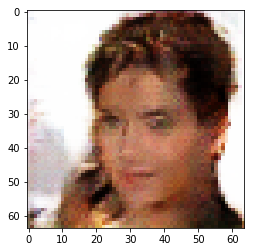





Epoch: [ 9] [ 841/1761] time: 175704.9568, d_loss: 1.68206871, g_loss: 0.55095196
Epoch: [ 9] [ 866/1761] time: 176155.9735, d_loss: 1.39772785, g_loss: 0.56268454
Saved model
Epoch: [ 9] [ 891/1761] time: 176665.3707, d_loss: 1.48111582, g_loss: 0.44072384
Epoch: [ 9] [ 916/1761] time: 177163.5296, d_loss: 1.34473228, g_loss: 0.79739553
Saved model
Sample




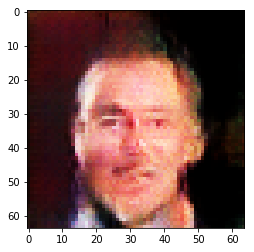





Epoch: [ 9] [ 941/1761] time: 177635.3360, d_loss: 1.45384002, g_loss: 1.27244449
Epoch: [ 9] [ 966/1761] time: 178117.7637, d_loss: 1.58104432, g_loss: 0.54887307
Saved model
Epoch: [ 9] [ 991/1761] time: 178586.4002, d_loss: 1.20602775, g_loss: 0.75728786
Epoch: [ 9] [1016/1761] time: 179045.8779, d_loss: 1.38189805, g_loss: 0.91388941
Saved model
Sample




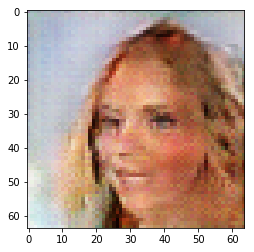





Epoch: [ 9] [1041/1761] time: 179503.3318, d_loss: 1.28547239, g_loss: 0.75496793
Epoch: [ 9] [1066/1761] time: 179958.0990, d_loss: 1.37349272, g_loss: 0.58634102
Saved model
Epoch: [ 9] [1091/1761] time: 180444.2828, d_loss: 1.34077954, g_loss: 0.49462968
Epoch: [ 9] [1116/1761] time: 180883.2948, d_loss: 1.35661912, g_loss: 0.78238422
Saved model
Sample




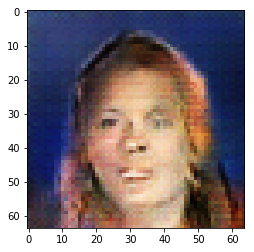





Epoch: [ 9] [1141/1761] time: 181315.0132, d_loss: 1.50566840, g_loss: 0.47916740
Epoch: [ 9] [1166/1761] time: 181752.6889, d_loss: 1.77418602, g_loss: 0.43189770
Saved model
Epoch: [ 9] [1191/1761] time: 182185.6833, d_loss: 1.16358078, g_loss: 0.88435769
Epoch: [ 9] [1216/1761] time: 182642.9732, d_loss: 1.48408949, g_loss: 0.43125772
Saved model
Sample




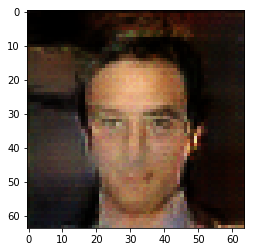





Epoch: [ 9] [1241/1761] time: 183140.6218, d_loss: 1.51637053, g_loss: 0.65519154
Epoch: [ 9] [1266/1761] time: 183576.3958, d_loss: 1.44819069, g_loss: 0.49356365
Saved model
Epoch: [ 9] [1291/1761] time: 184016.4812, d_loss: 1.14401650, g_loss: 0.88470626
Epoch: [ 9] [1316/1761] time: 184454.6020, d_loss: 1.48152566, g_loss: 0.44170392
Saved model
Sample




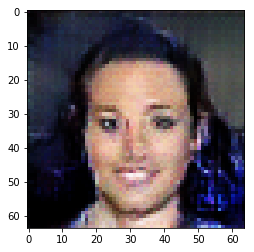





Epoch: [ 9] [1341/1761] time: 184898.5485, d_loss: 1.28723478, g_loss: 0.53341138
Epoch: [ 9] [1366/1761] time: 185338.8379, d_loss: 1.27847052, g_loss: 0.65884435
Saved model
Epoch: [ 9] [1391/1761] time: 185782.8405, d_loss: 1.65716970, g_loss: 0.52871364
Epoch: [ 9] [1416/1761] time: 186236.1933, d_loss: 1.24295390, g_loss: 0.67928213
Saved model
Sample




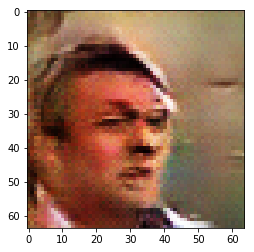





Epoch: [ 9] [1441/1761] time: 186695.3795, d_loss: 1.22878218, g_loss: 1.14605069
Epoch: [ 9] [1466/1761] time: 187150.3345, d_loss: 1.26756263, g_loss: 0.83552259
Saved model
Epoch: [ 9] [1491/1761] time: 187611.6351, d_loss: 1.14390087, g_loss: 0.86174601
Epoch: [ 9] [1516/1761] time: 188040.6781, d_loss: 1.21993184, g_loss: 0.84620762
Saved model
Sample




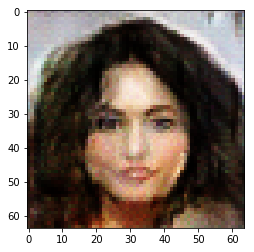





Epoch: [ 9] [1541/1761] time: 188470.0758, d_loss: 1.35278511, g_loss: 0.72569859
Epoch: [ 9] [1566/1761] time: 188893.6384, d_loss: 1.42494154, g_loss: 0.51603746
Saved model
Epoch: [ 9] [1591/1761] time: 189320.4647, d_loss: 1.22452199, g_loss: 0.79178011
Epoch: [ 9] [1616/1761] time: 189751.8109, d_loss: 1.24369597, g_loss: 0.81462729
Saved model
Sample




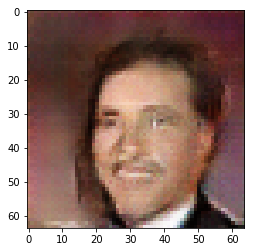





Epoch: [ 9] [1641/1761] time: 190190.1050, d_loss: 1.32182705, g_loss: 0.56576383
Epoch: [ 9] [1666/1761] time: 190624.4026, d_loss: 1.41707671, g_loss: 0.54072922
Saved model
Epoch: [ 9] [1691/1761] time: 191061.4344, d_loss: 1.28797984, g_loss: 0.71192610
Epoch: [ 9] [1716/1761] time: 191494.2299, d_loss: 1.57693386, g_loss: 0.36423331
Saved model
Sample




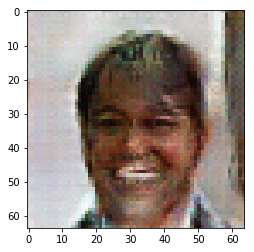





Epoch: [ 9] [1741/1761] time: 191931.5026, d_loss: 1.38214314, g_loss: 0.48799896
Epoch: [10] [   5/1761] time: 192364.1568, d_loss: 1.72679603, g_loss: 0.88746858
Saved model
Epoch: [10] [  30/1761] time: 192799.2848, d_loss: 1.22982526, g_loss: 1.29996133
Epoch: [10] [  55/1761] time: 193231.5897, d_loss: 1.33637547, g_loss: 0.58862531
Saved model
Sample




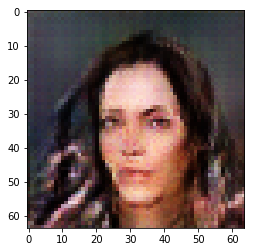





Epoch: [10] [  80/1761] time: 193668.8624, d_loss: 1.56998277, g_loss: 0.39846534
Epoch: [10] [ 105/1761] time: 194101.2507, d_loss: 1.48784304, g_loss: 0.49833935
Saved model
Epoch: [10] [ 130/1761] time: 194534.9835, d_loss: 1.55243731, g_loss: 0.43296838
Epoch: [10] [ 155/1761] time: 194966.3566, d_loss: 1.43868971, g_loss: 0.47856158
Saved model
Sample




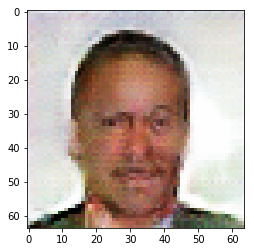





Epoch: [10] [ 180/1761] time: 195402.8541, d_loss: 1.25540018, g_loss: 0.59780842
Epoch: [10] [ 205/1761] time: 195834.9773, d_loss: 1.31328869, g_loss: 0.61537665
Saved model
Epoch: [10] [ 230/1761] time: 196269.1265, d_loss: 1.29670537, g_loss: 0.62788892
Epoch: [10] [ 255/1761] time: 196701.5502, d_loss: 1.23180735, g_loss: 0.71915841
Saved model
Sample




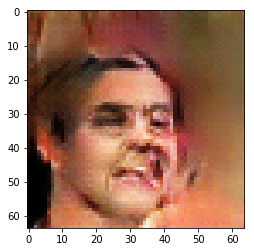





Epoch: [10] [ 280/1761] time: 197138.1535, d_loss: 1.31143177, g_loss: 0.58099008
Epoch: [10] [ 305/1761] time: 197570.3048, d_loss: 1.28721535, g_loss: 0.98485070
Saved model
Epoch: [10] [ 330/1761] time: 198005.3386, d_loss: 1.33270562, g_loss: 0.59154773
Epoch: [10] [ 355/1761] time: 198436.5576, d_loss: 1.28406644, g_loss: 0.91274744
Saved model
Sample




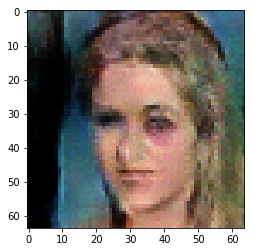





Epoch: [10] [ 380/1761] time: 229547.7102, d_loss: 1.37680244, g_loss: 1.05017042
Epoch: [10] [ 405/1761] time: 229977.9004, d_loss: 1.25981688, g_loss: 0.74342090
Saved model
Epoch: [10] [ 430/1761] time: 230404.5273, d_loss: 1.24199271, g_loss: 0.70731109
Epoch: [10] [ 455/1761] time: 230826.2047, d_loss: 1.37523842, g_loss: 1.25974369
Saved model
Sample




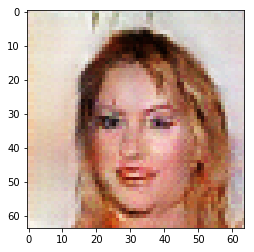





Epoch: [10] [ 480/1761] time: 231251.4491, d_loss: 1.44562984, g_loss: 1.58627117
Epoch: [10] [ 505/1761] time: 231678.2959, d_loss: 1.27198517, g_loss: 1.40022612
Saved model
Epoch: [10] [ 530/1761] time: 232110.9385, d_loss: 1.40205121, g_loss: 0.71102309
Epoch: [10] [ 555/1761] time: 232541.5644, d_loss: 1.33902645, g_loss: 0.56359434
Saved model
Sample




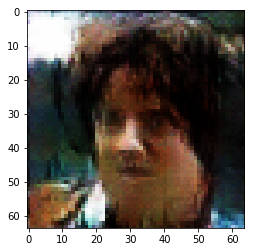





Epoch: [10] [ 580/1761] time: 232985.6352, d_loss: 1.48120093, g_loss: 1.32886028
Epoch: [10] [ 605/1761] time: 233417.6586, d_loss: 1.37973571, g_loss: 0.78402448
Saved model
Epoch: [10] [ 630/1761] time: 233851.5121, d_loss: 1.19574511, g_loss: 1.01673102
Epoch: [10] [ 655/1761] time: 234283.0473, d_loss: 1.32669604, g_loss: 0.63276595
Saved model
Sample




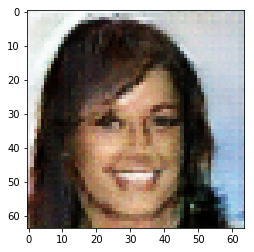





Epoch: [10] [ 680/1761] time: 234718.9632, d_loss: 1.60676706, g_loss: 0.36737585
Epoch: [10] [ 705/1761] time: 235150.9209, d_loss: 1.34734416, g_loss: 0.62264764
Saved model
Epoch: [10] [ 730/1761] time: 235583.6239, d_loss: 1.25998151, g_loss: 0.70579404
Epoch: [10] [ 755/1761] time: 236031.6390, d_loss: 1.22604167, g_loss: 0.74880934
Saved model
Sample




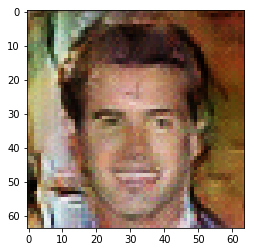





Epoch: [10] [ 780/1761] time: 236477.0847, d_loss: 1.32599497, g_loss: 0.64192319
Epoch: [10] [ 805/1761] time: 236903.2502, d_loss: 1.46985769, g_loss: 0.75073278
Saved model
Epoch: [10] [ 830/1761] time: 237327.9389, d_loss: 1.20002961, g_loss: 0.79208958
Epoch: [10] [ 855/1761] time: 237758.4574, d_loss: 1.36555076, g_loss: 0.56361115
Saved model
Sample




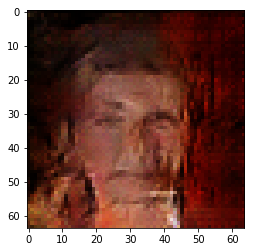





Epoch: [10] [ 880/1761] time: 238220.6719, d_loss: 1.14814544, g_loss: 0.73456746
Epoch: [10] [ 905/1761] time: 238644.6084, d_loss: 1.68739390, g_loss: 0.46930030
Saved model
Epoch: [10] [ 930/1761] time: 239069.5592, d_loss: 1.27854371, g_loss: 1.00479364
Epoch: [10] [ 955/1761] time: 239493.1846, d_loss: 1.98342752, g_loss: 0.22323619
Saved model
Sample




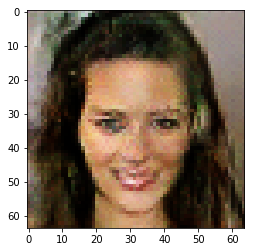





Epoch: [10] [ 980/1761] time: 239921.0579, d_loss: 1.23651934, g_loss: 1.14480805
Epoch: [10] [1005/1761] time: 240348.7929, d_loss: 1.24683022, g_loss: 0.69452250
Saved model
Epoch: [10] [1030/1761] time: 240780.6865, d_loss: 1.20191777, g_loss: 1.13788640
Epoch: [10] [1055/1761] time: 241207.5946, d_loss: 1.46423852, g_loss: 0.81609535
Saved model
Sample




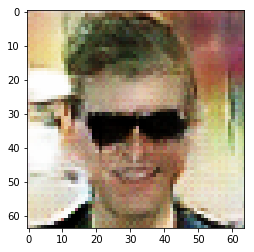





Epoch: [10] [1080/1761] time: 241638.7668, d_loss: 1.49720526, g_loss: 0.39098346
Epoch: [10] [1105/1761] time: 242077.5449, d_loss: 1.43672276, g_loss: 0.58594644
Saved model
Epoch: [10] [1130/1761] time: 242551.4133, d_loss: 1.31599283, g_loss: 0.72977281
Epoch: [10] [1155/1761] time: 243026.7917, d_loss: 1.46501851, g_loss: 0.55319941
Saved model
Sample




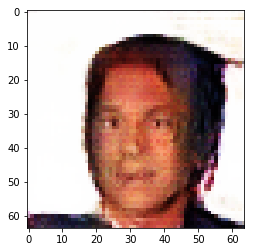





Epoch: [10] [1180/1761] time: 243525.1633, d_loss: 1.53366327, g_loss: 0.60137010
Epoch: [10] [1205/1761] time: 244020.4667, d_loss: 1.54650581, g_loss: 0.36542603
Saved model
Epoch: [10] [1230/1761] time: 244509.6072, d_loss: 1.63036740, g_loss: 0.42046452
Epoch: [10] [1255/1761] time: 244967.3213, d_loss: 1.32568777, g_loss: 0.68769956
Saved model
Sample




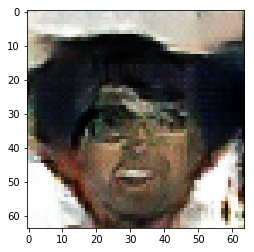





Epoch: [10] [1280/1761] time: 245427.4325, d_loss: 1.71372318, g_loss: 0.39754927
Epoch: [10] [1305/1761] time: 245884.0115, d_loss: 1.43233132, g_loss: 0.52815193
Saved model
Epoch: [10] [1330/1761] time: 246363.9349, d_loss: 1.18143892, g_loss: 0.90915215
Epoch: [10] [1355/1761] time: 246827.3430, d_loss: 1.45764339, g_loss: 0.60162175
Saved model
Sample




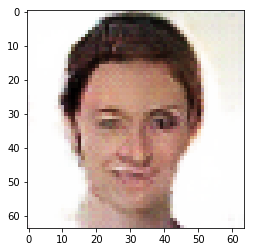





Epoch: [10] [1380/1761] time: 247269.1279, d_loss: 1.28204060, g_loss: 0.60271901
Epoch: [10] [1405/1761] time: 247757.4489, d_loss: 1.20196116, g_loss: 0.97829461
Saved model
Epoch: [10] [1430/1761] time: 248248.5500, d_loss: 1.34374988, g_loss: 0.74126005
Epoch: [10] [1455/1761] time: 248748.8963, d_loss: 1.18187690, g_loss: 1.18151832
Saved model
Sample




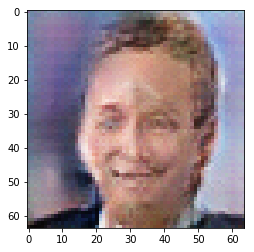





Epoch: [10] [1480/1761] time: 249222.5328, d_loss: 1.53136301, g_loss: 0.41394791
Epoch: [10] [1505/1761] time: 249705.3243, d_loss: 1.23116541, g_loss: 0.89350557
Saved model
Epoch: [10] [1530/1761] time: 250176.1113, d_loss: 1.27556896, g_loss: 0.97905910
Epoch: [10] [1555/1761] time: 250667.1456, d_loss: 1.32283115, g_loss: 1.00166559
Saved model
Sample




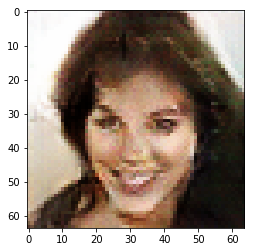





Epoch: [10] [1580/1761] time: 251168.4649, d_loss: 1.29717684, g_loss: 0.60610348
Epoch: [10] [1605/1761] time: 251658.3725, d_loss: 1.21605039, g_loss: 0.80954611
Saved model
Epoch: [10] [1630/1761] time: 252176.2720, d_loss: 1.32443655, g_loss: 0.65777802
Epoch: [10] [1655/1761] time: 252664.2205, d_loss: 1.19378591, g_loss: 1.32152700
Saved model
Sample




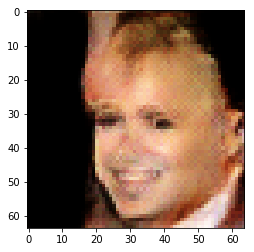





Epoch: [10] [1680/1761] time: 253175.6260, d_loss: 1.34642553, g_loss: 0.57365865
Epoch: [10] [1705/1761] time: 253687.7574, d_loss: 1.28453302, g_loss: 0.57589793
Saved model
Epoch: [10] [1730/1761] time: 254184.1470, d_loss: 1.62875819, g_loss: 0.39663380
Epoch: [10] [1755/1761] time: 254673.7835, d_loss: 1.56963646, g_loss: 0.39801380
Saved model
Sample




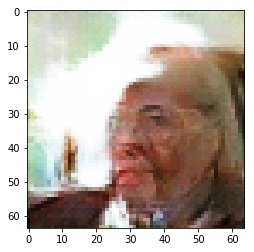





Epoch: [11] [  19/1761] time: 255184.1562, d_loss: 1.30625045, g_loss: 0.78090084
Epoch: [11] [  44/1761] time: 255674.7034, d_loss: 1.34471023, g_loss: 1.20795321
Saved model
Epoch: [11] [  69/1761] time: 256142.8499, d_loss: 1.23382425, g_loss: 0.63391179
Epoch: [11] [  94/1761] time: 256590.9408, d_loss: 1.27278364, g_loss: 0.77696872
Saved model
Sample




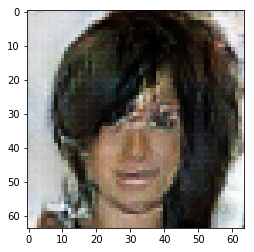





Epoch: [11] [ 119/1761] time: 257044.8937, d_loss: 1.36378801, g_loss: 0.50836962
Epoch: [11] [ 144/1761] time: 257572.1284, d_loss: 1.55537176, g_loss: 0.35698289
Saved model
Epoch: [11] [ 169/1761] time: 258055.8460, d_loss: 1.30309451, g_loss: 0.59431612
Epoch: [11] [ 194/1761] time: 258540.1303, d_loss: 1.14678526, g_loss: 0.74130344
Saved model
Sample




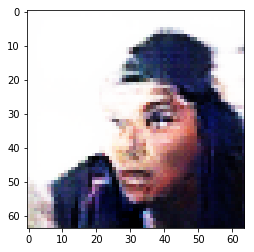





Epoch: [11] [ 219/1761] time: 259055.0507, d_loss: 1.31035805, g_loss: 0.92843562
Epoch: [11] [ 244/1761] time: 259521.5603, d_loss: 1.34256852, g_loss: 0.66904086
Saved model
Epoch: [11] [ 269/1761] time: 260669.1247, d_loss: 1.36356521, g_loss: 0.47424722
Epoch: [11] [ 294/1761] time: 261852.5809, d_loss: 1.52929497, g_loss: 0.34586734
Saved model
Sample




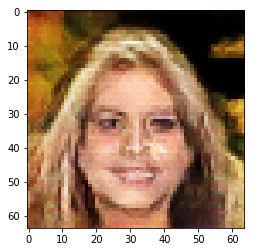





Epoch: [11] [ 319/1761] time: 263125.2128, d_loss: 1.52737021, g_loss: 0.45443642
Epoch: [11] [ 344/1761] time: 264375.0834, d_loss: 1.73407269, g_loss: 0.27467901
Saved model
Epoch: [11] [ 369/1761] time: 265655.9778, d_loss: 1.26010275, g_loss: 0.74312937
Epoch: [11] [ 394/1761] time: 267009.1042, d_loss: 1.40006888, g_loss: 0.70148623
Saved model
Sample




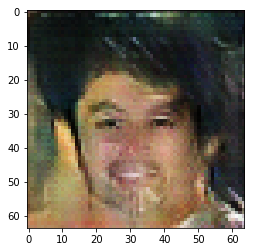





Epoch: [11] [ 419/1761] time: 268377.9274, d_loss: 1.23691106, g_loss: 0.74514705
Epoch: [11] [ 444/1761] time: 269663.1079, d_loss: 1.27109194, g_loss: 1.28211188
Saved model
Epoch: [11] [ 469/1761] time: 270985.3681, d_loss: 1.26460218, g_loss: 1.10117137
Epoch: [11] [ 494/1761] time: 272250.3359, d_loss: 1.31382442, g_loss: 0.56814480
Saved model
Sample




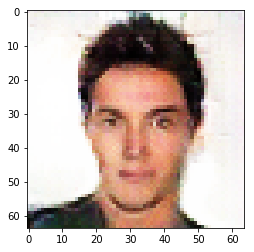





Epoch: [11] [ 519/1761] time: 317480.8867, d_loss: 1.20856333, g_loss: 0.73066461
Epoch: [11] [ 544/1761] time: 317926.3110, d_loss: 1.09973001, g_loss: 1.08392346
Saved model
Epoch: [11] [ 569/1761] time: 318356.8675, d_loss: 1.43272495, g_loss: 0.54556698
Epoch: [11] [ 594/1761] time: 318785.0670, d_loss: 1.35818458, g_loss: 0.59470522
Saved model
Sample




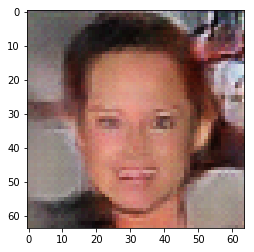





Epoch: [11] [ 619/1761] time: 319218.9629, d_loss: 1.28730786, g_loss: 0.56804574
Epoch: [11] [ 644/1761] time: 319707.8747, d_loss: 1.22631705, g_loss: 0.61237800
Saved model
Epoch: [11] [ 669/1761] time: 320228.8750, d_loss: 1.38959539, g_loss: 0.42828459
Epoch: [11] [ 694/1761] time: 320758.2899, d_loss: 1.98254490, g_loss: 0.19984850
Saved model
Sample




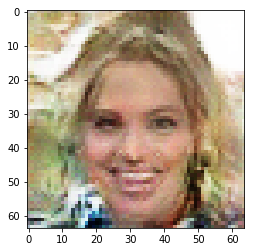





Epoch: [11] [ 719/1761] time: 321262.2105, d_loss: 1.33603823, g_loss: 0.56613767
Epoch: [11] [ 744/1761] time: 321730.4983, d_loss: 1.26351452, g_loss: 0.65886801
Saved model
Epoch: [11] [ 769/1761] time: 322192.0368, d_loss: 1.18399477, g_loss: 0.75985372
Epoch: [11] [ 794/1761] time: 322635.6070, d_loss: 1.20444465, g_loss: 0.78064954
Saved model
Sample




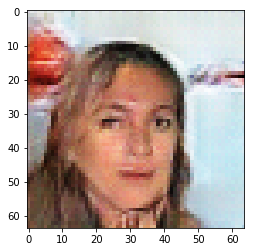





Epoch: [11] [ 819/1761] time: 323077.0756, d_loss: 1.18773758, g_loss: 0.62862837
Epoch: [11] [ 844/1761] time: 323507.6402, d_loss: 1.22039557, g_loss: 1.00684404
Saved model
Epoch: [11] [ 869/1761] time: 323940.0881, d_loss: 1.97303665, g_loss: 0.22145763
Epoch: [11] [ 894/1761] time: 324370.0633, d_loss: 1.51811600, g_loss: 0.42051393
Saved model
Sample




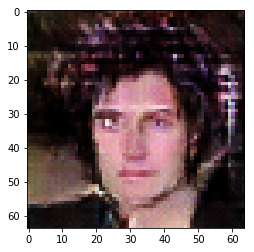





Epoch: [11] [ 919/1761] time: 324815.1467, d_loss: 1.39033818, g_loss: 0.97020662
Epoch: [11] [ 944/1761] time: 325252.9160, d_loss: 1.32416582, g_loss: 1.33009911
Saved model
Epoch: [11] [ 969/1761] time: 325693.5311, d_loss: 1.17578363, g_loss: 0.87714028
Epoch: [11] [ 994/1761] time: 326130.8003, d_loss: 1.23233366, g_loss: 1.01599169
Saved model
Sample




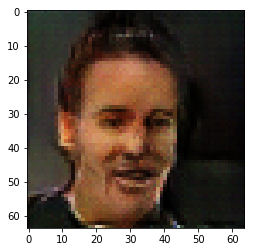





Epoch: [11] [1019/1761] time: 326573.1441, d_loss: 1.17912316, g_loss: 0.85683191
Epoch: [11] [1044/1761] time: 327014.7934, d_loss: 1.13726354, g_loss: 1.10142112
Saved model
Epoch: [11] [1069/1761] time: 327483.4158, d_loss: 1.32010961, g_loss: 0.80646527
Epoch: [11] [1094/1761] time: 327951.7752, d_loss: 1.46610463, g_loss: 0.61842465
Saved model
Sample




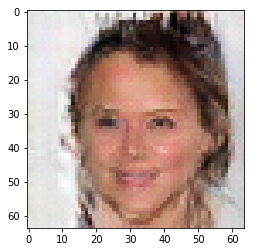





Epoch: [11] [1119/1761] time: 328454.2669, d_loss: 1.54304576, g_loss: 0.40113398
Epoch: [11] [1144/1761] time: 328957.4533, d_loss: 1.33746254, g_loss: 0.58984852
Saved model
Epoch: [11] [1169/1761] time: 329474.8615, d_loss: 1.26055884, g_loss: 0.60458452
Epoch: [11] [1194/1761] time: 329974.4255, d_loss: 1.09746683, g_loss: 0.89526987
Saved model
Sample




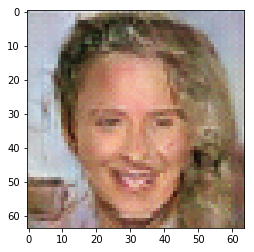





Epoch: [11] [1219/1761] time: 330475.7624, d_loss: 1.69492507, g_loss: 0.42944071
Epoch: [11] [1244/1761] time: 330974.2407, d_loss: 1.25236678, g_loss: 0.60520035
Saved model
Epoch: [11] [1269/1761] time: 331461.1302, d_loss: 1.37005389, g_loss: 0.60692883
Epoch: [11] [1294/1761] time: 331949.4290, d_loss: 1.32820845, g_loss: 1.19229388
Saved model
Sample




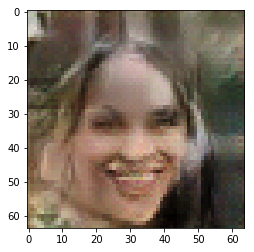





Epoch: [11] [1319/1761] time: 332436.3147, d_loss: 1.32156551, g_loss: 0.96717811
Epoch: [11] [1344/1761] time: 332916.4914, d_loss: 1.24018896, g_loss: 0.75001824
Saved model
Epoch: [11] [1369/1761] time: 333389.0461, d_loss: 1.17955315, g_loss: 0.75102079
Epoch: [11] [1394/1761] time: 333855.5293, d_loss: 1.29740787, g_loss: 0.71066523
Saved model
Sample




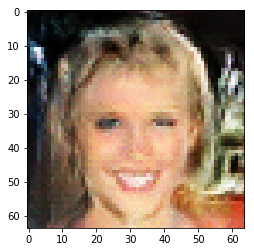





Epoch: [11] [1419/1761] time: 334349.1532, d_loss: 1.38514066, g_loss: 1.72192132
Epoch: [11] [1444/1761] time: 334842.4968, d_loss: 1.47022724, g_loss: 0.45291489
Saved model
Epoch: [11] [1469/1761] time: 335327.8303, d_loss: 1.23798835, g_loss: 0.85571241
Epoch: [11] [1494/1761] time: 335778.3680, d_loss: 1.30312681, g_loss: 1.26670516
Saved model
Sample




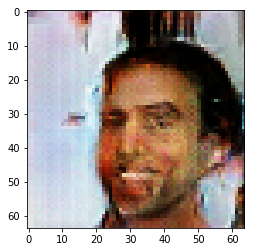





Epoch: [11] [1519/1761] time: 336234.2000, d_loss: 1.40334404, g_loss: 0.73596436
Epoch: [11] [1544/1761] time: 336695.5755, d_loss: 1.16542280, g_loss: 1.65815282
Saved model
Epoch: [11] [1569/1761] time: 337173.0776, d_loss: 1.27917719, g_loss: 0.56420112
Epoch: [11] [1594/1761] time: 337647.4071, d_loss: 1.52780533, g_loss: 0.41039160
Saved model
Sample




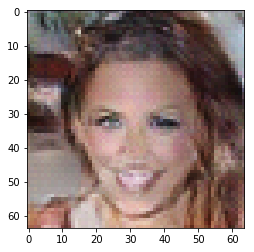





Epoch: [11] [1619/1761] time: 338122.2586, d_loss: 1.42363882, g_loss: 0.52007365
Epoch: [11] [1644/1761] time: 338577.1904, d_loss: 1.38924015, g_loss: 0.55059707
Saved model
Epoch: [11] [1669/1761] time: 339041.6790, d_loss: 1.29636371, g_loss: 0.78470612
Epoch: [11] [1694/1761] time: 339495.3254, d_loss: 1.24604893, g_loss: 0.79028034
Saved model
Sample




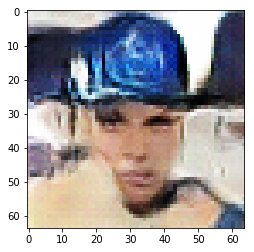





Epoch: [11] [1719/1761] time: 339944.4677, d_loss: 1.31916976, g_loss: 0.49365863
Epoch: [11] [1744/1761] time: 340511.4520, d_loss: 1.70908296, g_loss: 0.28599659
Saved model
Epoch: [12] [   8/1761] time: 341697.2369, d_loss: 2.12653112, g_loss: 0.35579407
Epoch: [12] [  33/1761] time: 342840.7808, d_loss: 1.89646780, g_loss: 0.24126139
Saved model
Sample




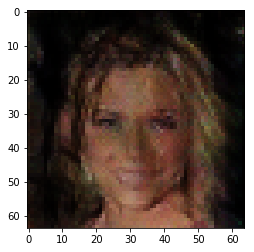





Epoch: [12] [  58/1761] time: 343999.2855, d_loss: 1.49909508, g_loss: 0.51067579
Epoch: [12] [  83/1761] time: 345006.9321, d_loss: 1.36321890, g_loss: 0.49514860
Saved model
Epoch: [12] [ 108/1761] time: 345528.3140, d_loss: 1.14655912, g_loss: 0.91826421
Epoch: [12] [ 133/1761] time: 346034.9508, d_loss: 1.42218184, g_loss: 0.74315333
Saved model
Sample




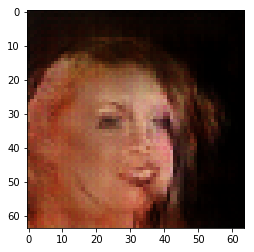





Epoch: [12] [ 158/1761] time: 346557.7874, d_loss: 1.34079921, g_loss: 1.01594687
Epoch: [12] [ 183/1761] time: 347074.8985, d_loss: 1.22550225, g_loss: 0.98421359
Saved model
Epoch: [12] [ 208/1761] time: 347598.0874, d_loss: 1.41129613, g_loss: 0.61172616
Epoch: [12] [ 233/1761] time: 348080.3184, d_loss: 1.28114915, g_loss: 0.55144441
Saved model
Sample




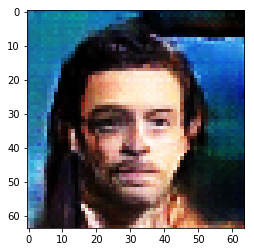





Epoch: [12] [ 258/1761] time: 348587.3697, d_loss: 1.17969632, g_loss: 0.80263090
Epoch: [12] [ 283/1761] time: 349091.8194, d_loss: 1.41496360, g_loss: 1.29520154
Saved model
Epoch: [12] [ 308/1761] time: 349601.2931, d_loss: 1.24818063, g_loss: 0.91125864
Epoch: [12] [ 333/1761] time: 350106.6499, d_loss: 1.63115561, g_loss: 0.65292156
Saved model
Sample




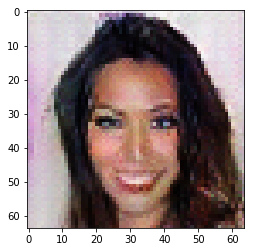





Epoch: [12] [ 358/1761] time: 350611.8827, d_loss: 1.40029883, g_loss: 0.55192411
Epoch: [12] [ 383/1761] time: 351109.4521, d_loss: 1.21714211, g_loss: 1.55716896
Saved model
Epoch: [12] [ 408/1761] time: 351602.1607, d_loss: 1.25507593, g_loss: 0.56886756
Epoch: [12] [ 433/1761] time: 352090.8153, d_loss: 1.42947972, g_loss: 0.61914122
Saved model
Sample




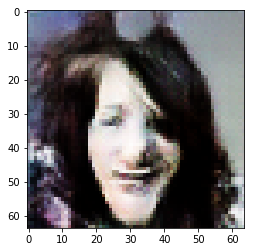





Epoch: [12] [ 458/1761] time: 352571.2615, d_loss: 1.18444324, g_loss: 0.80988216
Epoch: [12] [ 483/1761] time: 353071.4366, d_loss: 1.14357591, g_loss: 0.92106247
Saved model
Epoch: [12] [ 508/1761] time: 353565.2200, d_loss: 1.43900979, g_loss: 1.07733369
Epoch: [12] [ 533/1761] time: 354060.9362, d_loss: 1.39646268, g_loss: 0.47882700
Saved model
Sample




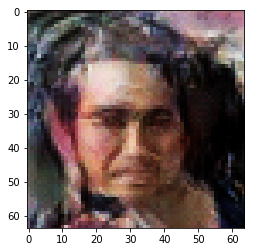





Epoch: [12] [ 558/1761] time: 354551.5201, d_loss: 1.08550501, g_loss: 0.92930663
Epoch: [12] [ 583/1761] time: 355034.9456, d_loss: 1.27690947, g_loss: 1.13508010
Saved model
Epoch: [12] [ 608/1761] time: 355502.8252, d_loss: 1.15078723, g_loss: 1.24070835
Epoch: [12] [ 633/1761] time: 355965.8924, d_loss: 1.20653915, g_loss: 1.61443865
Saved model
Sample




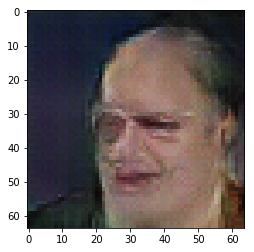





Epoch: [12] [ 658/1761] time: 356434.4084, d_loss: 1.15071011, g_loss: 0.70222402
Epoch: [12] [ 683/1761] time: 356894.5434, d_loss: 1.29965782, g_loss: 0.59295213
Saved model
Epoch: [12] [ 708/1761] time: 357362.6372, d_loss: 1.47446203, g_loss: 1.32686591
Epoch: [12] [ 733/1761] time: 357823.9944, d_loss: 1.14557552, g_loss: 0.65444249
Saved model
Sample




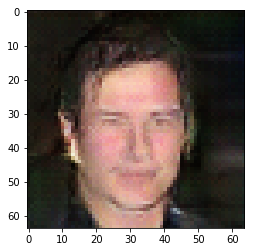





Epoch: [12] [ 758/1761] time: 358302.8658, d_loss: 1.29521084, g_loss: 0.65176022
Epoch: [12] [ 783/1761] time: 358787.8784, d_loss: 1.36680222, g_loss: 0.55003262
Saved model
Epoch: [12] [ 808/1761] time: 359275.2095, d_loss: 1.40467238, g_loss: 0.53848380
Epoch: [12] [ 833/1761] time: 359762.3688, d_loss: 1.60836124, g_loss: 0.42959201
Saved model
Sample




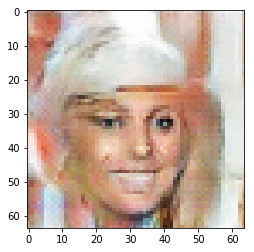





Epoch: [12] [ 858/1761] time: 360247.8004, d_loss: 1.46793234, g_loss: 0.57966202
Epoch: [12] [ 883/1761] time: 360731.6426, d_loss: 1.42411947, g_loss: 0.56200743
Saved model
Epoch: [12] [ 908/1761] time: 361226.4975, d_loss: 1.22760010, g_loss: 1.07446206
Epoch: [12] [ 933/1761] time: 361707.7903, d_loss: 1.15121722, g_loss: 1.26097453
Saved model
Sample




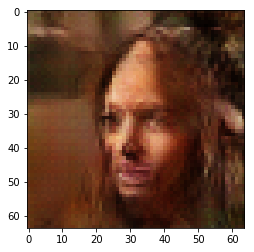





Epoch: [12] [ 958/1761] time: 362193.6869, d_loss: 1.12702036, g_loss: 1.22110116
Epoch: [12] [ 983/1761] time: 362649.7162, d_loss: 1.18514001, g_loss: 1.67227173
Saved model
Epoch: [12] [1008/1761] time: 363113.6208, d_loss: 1.20314264, g_loss: 0.70482302
Epoch: [12] [1033/1761] time: 363550.0904, d_loss: 1.12929606, g_loss: 1.19569874
Saved model
Sample




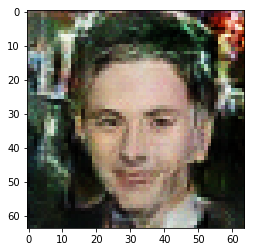





Epoch: [12] [1058/1761] time: 363994.0687, d_loss: 1.75162613, g_loss: 0.25555441
Epoch: [12] [1083/1761] time: 364431.3618, d_loss: 1.39122486, g_loss: 0.43580443
Saved model
Epoch: [12] [1108/1761] time: 364873.4184, d_loss: 1.33967185, g_loss: 0.92782795
Epoch: [12] [1133/1761] time: 365309.4782, d_loss: 1.17633462, g_loss: 0.74973941
Saved model
Sample




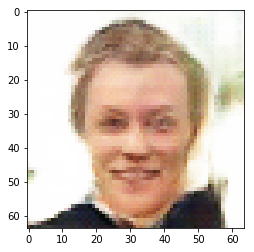





Epoch: [12] [1158/1761] time: 365752.6388, d_loss: 1.31620097, g_loss: 0.60986042
Epoch: [12] [1183/1761] time: 366189.4812, d_loss: 1.17229486, g_loss: 1.11491764
Saved model
Epoch: [12] [1208/1761] time: 366630.5411, d_loss: 1.21770632, g_loss: 0.75182623
Epoch: [12] [1233/1761] time: 367061.7827, d_loss: 1.82285106, g_loss: 0.30193159
Saved model
Sample




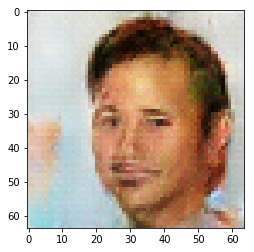





Epoch: [12] [1258/1761] time: 367497.4719, d_loss: 1.48744798, g_loss: 0.56382036
Epoch: [12] [1283/1761] time: 367927.1583, d_loss: 1.43643677, g_loss: 0.49661040
Saved model
Epoch: [12] [1308/1761] time: 368361.3932, d_loss: 1.33735728, g_loss: 0.56958544
Epoch: [12] [1333/1761] time: 368791.2996, d_loss: 1.34282768, g_loss: 0.49579287
Saved model
Sample




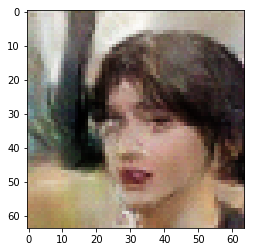





Epoch: [12] [1358/1761] time: 369226.2296, d_loss: 1.14254808, g_loss: 0.92955542
Epoch: [12] [1383/1761] time: 369655.4773, d_loss: 1.07785630, g_loss: 1.27774811
Saved model
Epoch: [12] [1408/1761] time: 370088.7916, d_loss: 1.29913449, g_loss: 1.22707629
Epoch: [12] [1433/1761] time: 370518.6769, d_loss: 1.10996509, g_loss: 1.50683880
Saved model
Sample




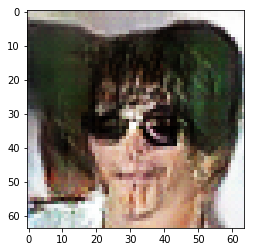





Epoch: [12] [1458/1761] time: 370953.8461, d_loss: 1.40984011, g_loss: 1.50995457
Epoch: [12] [1483/1761] time: 402674.6598, d_loss: 1.19335854, g_loss: 0.94713664
Saved model
Epoch: [12] [1508/1761] time: 403133.2043, d_loss: 1.26673698, g_loss: 0.60082281
Epoch: [12] [1533/1761] time: 403604.7565, d_loss: 1.30794382, g_loss: 0.66490507
Saved model
Sample




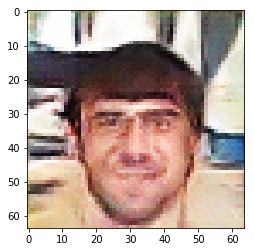





Epoch: [12] [1558/1761] time: 404043.0769, d_loss: 1.27498162, g_loss: 0.90999341
Epoch: [12] [1583/1761] time: 404478.8172, d_loss: 1.30111837, g_loss: 0.80268127
Saved model
Epoch: [12] [1608/1761] time: 404917.7391, d_loss: 1.23341584, g_loss: 0.80206680
Epoch: [12] [1633/1761] time: 405383.2303, d_loss: 1.27952707, g_loss: 0.74452323
Saved model
Sample




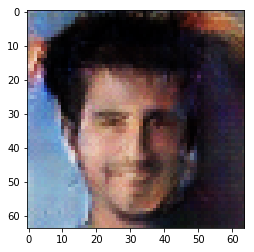





Epoch: [12] [1658/1761] time: 405836.3121, d_loss: 1.17144084, g_loss: 0.81768978
Epoch: [12] [1683/1761] time: 406299.7124, d_loss: 1.18965387, g_loss: 0.84216452
Saved model
Epoch: [12] [1708/1761] time: 406786.7506, d_loss: 1.22357237, g_loss: 1.16701245
Epoch: [12] [1733/1761] time: 407228.8290, d_loss: 1.26186967, g_loss: 1.13816929
Saved model
Sample




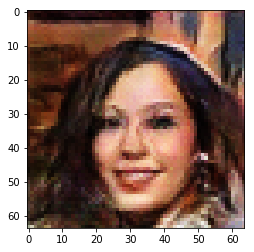





Epoch: [12] [1758/1761] time: 407667.1025, d_loss: 1.27578712, g_loss: 0.54957283
Epoch: [13] [  22/1761] time: 408099.1454, d_loss: 1.49254215, g_loss: 0.38376963
Saved model
Epoch: [13] [  47/1761] time: 408535.6502, d_loss: 1.39070559, g_loss: 0.54918927
Epoch: [13] [  72/1761] time: 408971.9438, d_loss: 1.21117091, g_loss: 0.68406427
Saved model
Sample




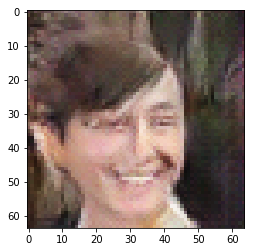





Epoch: [13] [  97/1761] time: 409418.7939, d_loss: 1.44288588, g_loss: 0.47599059
Epoch: [13] [ 122/1761] time: 409874.8197, d_loss: 1.30482113, g_loss: 0.98267263
Saved model
Epoch: [13] [ 147/1761] time: 410344.8675, d_loss: 1.36536121, g_loss: 0.53738296
Epoch: [13] [ 172/1761] time: 410833.2065, d_loss: 1.14181411, g_loss: 0.86263770
Saved model
Sample




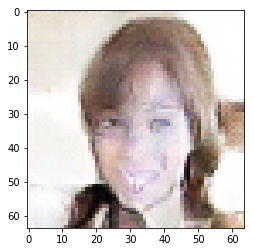





Epoch: [13] [ 197/1761] time: 411337.7409, d_loss: 1.37246525, g_loss: 0.52245951
Epoch: [13] [ 222/1761] time: 411842.3846, d_loss: 1.30065441, g_loss: 0.81048727
Saved model
Epoch: [13] [ 247/1761] time: 412377.4903, d_loss: 1.82964778, g_loss: 2.10177207
Epoch: [13] [ 272/1761] time: 412889.5435, d_loss: 1.82712567, g_loss: 0.26222304
Saved model
Sample




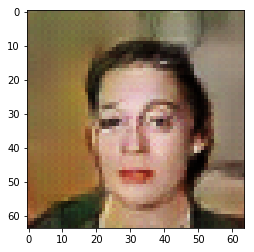





Epoch: [13] [ 297/1761] time: 413434.4576, d_loss: 1.64280152, g_loss: 0.37276852
Epoch: [13] [ 322/1761] time: 413956.8637, d_loss: 1.05268955, g_loss: 0.76596463
Saved model
Epoch: [13] [ 347/1761] time: 414469.8478, d_loss: 1.62011504, g_loss: 0.35527480
Epoch: [13] [ 372/1761] time: 414972.2707, d_loss: 1.51107585, g_loss: 0.45997912
Saved model
Sample




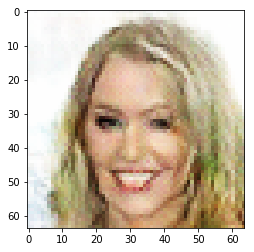





Epoch: [13] [ 397/1761] time: 415471.1989, d_loss: 1.29906058, g_loss: 1.26940548
Epoch: [13] [ 422/1761] time: 415918.0241, d_loss: 1.53371143, g_loss: 0.41846830
Saved model
Epoch: [13] [ 447/1761] time: 416407.5615, d_loss: 1.23444533, g_loss: 0.84368992
Epoch: [13] [ 472/1761] time: 416887.6898, d_loss: 1.18701696, g_loss: 0.59734488
Saved model
Sample




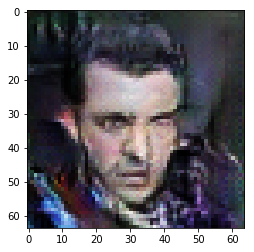





Epoch: [13] [ 497/1761] time: 417372.8217, d_loss: 1.30965447, g_loss: 1.19417048
Epoch: [13] [ 522/1761] time: 417847.5571, d_loss: 1.29799581, g_loss: 0.87403625
Saved model
Epoch: [13] [ 547/1761] time: 418321.0023, d_loss: 1.38517690, g_loss: 0.48957968
Epoch: [13] [ 572/1761] time: 418802.3168, d_loss: 1.10395968, g_loss: 0.84633505
Saved model
Sample




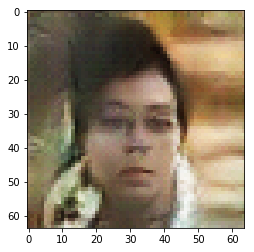





Epoch: [13] [ 597/1761] time: 419296.8741, d_loss: 1.27199674, g_loss: 0.59347498
Epoch: [13] [ 622/1761] time: 419784.9996, d_loss: 1.42011988, g_loss: 0.44200489
Saved model
Epoch: [13] [ 647/1761] time: 420274.0888, d_loss: 1.23172402, g_loss: 0.66799688
Epoch: [13] [ 672/1761] time: 420761.2512, d_loss: 1.21103072, g_loss: 0.91191912
Saved model
Sample




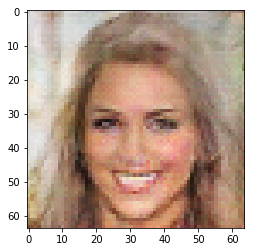





Epoch: [13] [ 697/1761] time: 421238.9178, d_loss: 1.31523728, g_loss: 0.48213607
Epoch: [13] [ 722/1761] time: 421703.8803, d_loss: 1.38290966, g_loss: 0.51748538
Saved model
Epoch: [13] [ 747/1761] time: 422172.6891, d_loss: 1.25966549, g_loss: 0.67325479
Epoch: [13] [ 772/1761] time: 422641.5368, d_loss: 1.32523048, g_loss: 0.51285213
Saved model
Sample




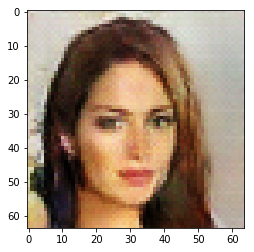





Epoch: [13] [ 797/1761] time: 423102.9781, d_loss: 1.24898005, g_loss: 0.59787202
Epoch: [13] [ 822/1761] time: 423580.4504, d_loss: 1.62872326, g_loss: 0.36103883
Saved model
Epoch: [13] [ 847/1761] time: 424098.0758, d_loss: 1.16472602, g_loss: 0.71535945
Epoch: [13] [ 872/1761] time: 424606.7474, d_loss: 1.27530909, g_loss: 0.69986808
Saved model
Sample




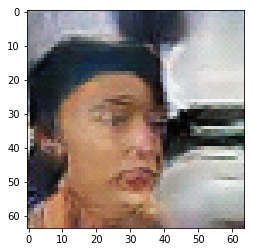





Epoch: [13] [ 897/1761] time: 425112.7207, d_loss: 2.05633259, g_loss: 0.19402058
Epoch: [13] [ 922/1761] time: 425624.4575, d_loss: 1.73838520, g_loss: 0.29484811
Saved model
Epoch: [13] [ 947/1761] time: 426110.2302, d_loss: 1.60045397, g_loss: 0.48766121
Epoch: [13] [ 972/1761] time: 426572.2660, d_loss: 1.37921762, g_loss: 0.55163825
Saved model
Sample




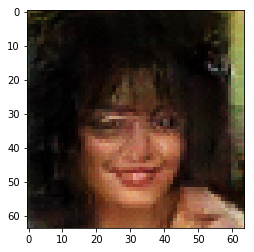





Epoch: [13] [ 997/1761] time: 427039.1285, d_loss: 1.90697336, g_loss: 0.26127297
Epoch: [13] [1022/1761] time: 427500.5519, d_loss: 1.21593273, g_loss: 0.68506426
Saved model
Epoch: [13] [1047/1761] time: 427962.8372, d_loss: 1.21232951, g_loss: 0.73663914
Epoch: [13] [1072/1761] time: 428415.6807, d_loss: 1.32412696, g_loss: 0.56488836
Saved model
Sample




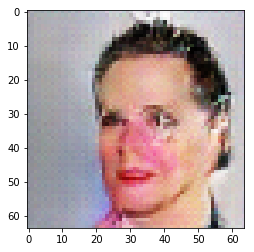





Epoch: [13] [1097/1761] time: 428875.6882, d_loss: 1.58381939, g_loss: 0.43488896
Epoch: [13] [1122/1761] time: 429330.2995, d_loss: 1.17867434, g_loss: 0.76053810
Saved model
Epoch: [13] [1147/1761] time: 429793.5793, d_loss: 1.37473512, g_loss: 0.54360062
Epoch: [13] [1172/1761] time: 430248.3894, d_loss: 1.83534360, g_loss: 0.29556814
Saved model
Sample




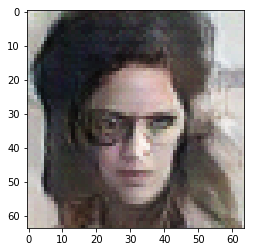





Epoch: [13] [1197/1761] time: 430708.9317, d_loss: 1.31462264, g_loss: 0.58036727
Epoch: [13] [1222/1761] time: 431163.6806, d_loss: 1.49473810, g_loss: 0.49819189
Saved model
Epoch: [13] [1247/1761] time: 431624.6554, d_loss: 2.24194288, g_loss: 0.22239739
Epoch: [13] [1272/1761] time: 432079.5330, d_loss: 1.57091403, g_loss: 0.39047229
Saved model
Sample




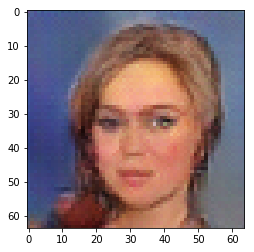





Epoch: [13] [1297/1761] time: 432542.5986, d_loss: 1.99107027, g_loss: 1.94033313
Epoch: [13] [1322/1761] time: 433020.3622, d_loss: 1.76493776, g_loss: 0.35264471
Saved model
Epoch: [13] [1347/1761] time: 433524.3817, d_loss: 1.21650028, g_loss: 1.45513010
Epoch: [13] [1372/1761] time: 434032.8897, d_loss: 1.24495840, g_loss: 0.58043849
Saved model
Sample




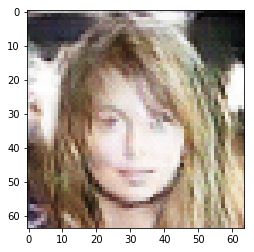





Epoch: [13] [1397/1761] time: 434492.5868, d_loss: 1.28747237, g_loss: 0.95058507
Epoch: [13] [1422/1761] time: 434941.0269, d_loss: 1.44537473, g_loss: 0.43450290
Saved model
Epoch: [13] [1447/1761] time: 435394.5066, d_loss: 1.40087056, g_loss: 0.89634967
Epoch: [13] [1472/1761] time: 435859.9531, d_loss: 1.54965901, g_loss: 1.62551725
Saved model
Sample




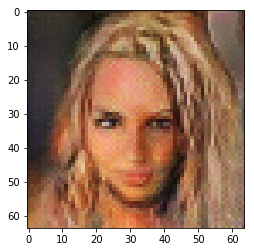





Epoch: [13] [1497/1761] time: 436353.7408, d_loss: 1.52460432, g_loss: 1.60419393
Epoch: [13] [1522/1761] time: 436871.6296, d_loss: 1.42681444, g_loss: 0.57200015
Saved model
Epoch: [13] [1547/1761] time: 437371.8921, d_loss: 1.27032232, g_loss: 0.57559299
Epoch: [13] [1572/1761] time: 437870.5375, d_loss: 1.39680862, g_loss: 0.49641955
Saved model
Sample




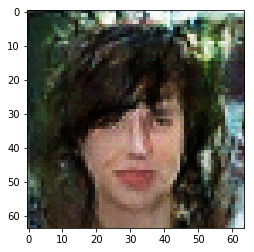





Epoch: [13] [1597/1761] time: 438348.1676, d_loss: 1.55720317, g_loss: 1.29403281
Epoch: [13] [1622/1761] time: 438782.0993, d_loss: 1.60658622, g_loss: 0.44099733
Saved model
Epoch: [13] [1647/1761] time: 439216.3283, d_loss: 1.82747507, g_loss: 0.34531942
Epoch: [13] [1672/1761] time: 439647.2740, d_loss: 1.21240664, g_loss: 0.82271874
Saved model
Sample




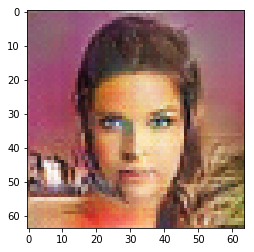





Epoch: [13] [1697/1761] time: 440088.8088, d_loss: 1.17591858, g_loss: 0.89973378
Epoch: [13] [1722/1761] time: 440527.0135, d_loss: 1.32485509, g_loss: 0.86368299
Saved model
Epoch: [13] [1747/1761] time: 440969.0130, d_loss: 1.27365947, g_loss: 0.97774708
Epoch: [14] [  11/1761] time: 441406.5006, d_loss: 1.16240048, g_loss: 1.56317067
Saved model
Sample




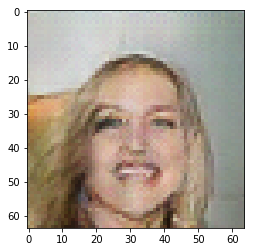





Epoch: [14] [  36/1761] time: 441849.3001, d_loss: 1.45216548, g_loss: 1.98906994
Epoch: [14] [  61/1761] time: 442304.6640, d_loss: 1.27943861, g_loss: 0.68292004
Saved model
Epoch: [14] [  86/1761] time: 442748.8174, d_loss: 1.23356032, g_loss: 0.70359945
Epoch: [14] [ 111/1761] time: 443180.7967, d_loss: 1.22135067, g_loss: 1.58105779
Saved model
Sample




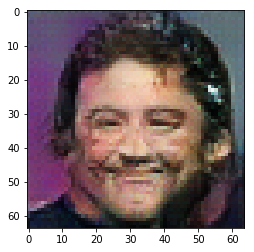





Epoch: [14] [ 136/1761] time: 443617.0877, d_loss: 1.17089272, g_loss: 1.09123945
Epoch: [14] [ 161/1761] time: 444047.9849, d_loss: 1.36091352, g_loss: 0.61927354
Saved model
Epoch: [14] [ 186/1761] time: 444488.7037, d_loss: 1.54251361, g_loss: 0.45584750
Epoch: [14] [ 211/1761] time: 444926.2582, d_loss: 1.09840941, g_loss: 0.99366510
Saved model
Sample




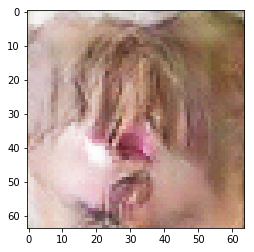





Epoch: [14] [ 236/1761] time: 445369.0135, d_loss: 1.31217051, g_loss: 0.66065311
Epoch: [14] [ 261/1761] time: 445806.5659, d_loss: 1.22999871, g_loss: 0.65154821
Saved model
Epoch: [14] [ 286/1761] time: 446249.5821, d_loss: 1.11180818, g_loss: 1.32011628
Epoch: [14] [ 311/1761] time: 446686.7185, d_loss: 1.22979200, g_loss: 0.92291045
Saved model
Sample




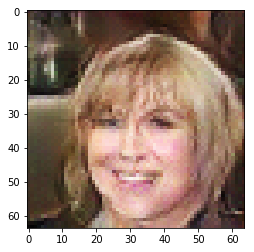





Epoch: [14] [ 336/1761] time: 447128.8935, d_loss: 1.43150353, g_loss: 0.58890820
Epoch: [14] [ 361/1761] time: 447566.4473, d_loss: 1.31651258, g_loss: 1.08294582
Saved model
Epoch: [14] [ 386/1761] time: 448006.5551, d_loss: 1.55999875, g_loss: 0.40830329
Epoch: [14] [ 411/1761] time: 448443.8006, d_loss: 1.28924561, g_loss: 0.71102166
Saved model
Sample




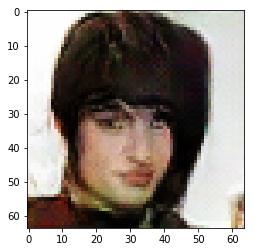





Epoch: [14] [ 436/1761] time: 448885.9579, d_loss: 1.66439295, g_loss: 0.34849167
Epoch: [14] [ 461/1761] time: 449323.3350, d_loss: 1.07276678, g_loss: 1.18662679
Saved model
Epoch: [14] [ 486/1761] time: 449762.3182, d_loss: 1.30622482, g_loss: 1.94557858
Epoch: [14] [ 511/1761] time: 450199.3592, d_loss: 1.24757075, g_loss: 0.67092705
Saved model
Sample




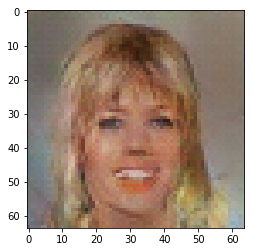





Epoch: [14] [ 536/1761] time: 450640.5671, d_loss: 1.37874770, g_loss: 0.62758529
Epoch: [14] [ 561/1761] time: 451077.2020, d_loss: 1.19562340, g_loss: 0.76242352
Saved model
Epoch: [14] [ 586/1761] time: 451520.1977, d_loss: 1.27374089, g_loss: 1.30452204
Epoch: [14] [ 611/1761] time: 451957.6332, d_loss: 1.02000582, g_loss: 0.91492873
Saved model
Sample




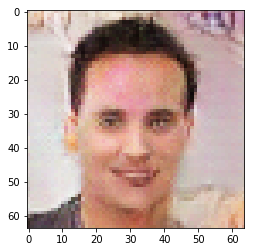





Epoch: [14] [ 636/1761] time: 452398.8179, d_loss: 1.29944682, g_loss: 0.63990420
Epoch: [14] [ 661/1761] time: 452834.7374, d_loss: 1.44730365, g_loss: 0.45137703
Saved model
Epoch: [14] [ 686/1761] time: 494646.1396, d_loss: 1.12054169, g_loss: 0.79354423
Epoch: [14] [ 711/1761] time: 495149.4279, d_loss: 1.76337361, g_loss: 0.26835465
Saved model
Sample




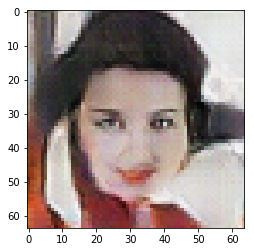





Epoch: [14] [ 736/1761] time: 495619.0276, d_loss: 1.10476518, g_loss: 0.87843996
Epoch: [14] [ 761/1761] time: 496076.2737, d_loss: 1.46244824, g_loss: 0.43087095
Saved model
Epoch: [14] [ 786/1761] time: 496534.0676, d_loss: 1.54391909, g_loss: 0.38795298
Epoch: [14] [ 811/1761] time: 496991.0354, d_loss: 1.55321145, g_loss: 0.44622314
Saved model
Sample




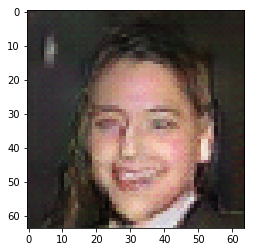





Epoch: [14] [ 836/1761] time: 497449.4274, d_loss: 1.32756639, g_loss: 1.62518716
Epoch: [14] [ 861/1761] time: 497899.3016, d_loss: 1.49082458, g_loss: 0.50475889
Saved model
Epoch: [14] [ 886/1761] time: 498361.1341, d_loss: 1.19709492, g_loss: 0.75302571
Epoch: [14] [ 911/1761] time: 498812.9247, d_loss: 1.39281392, g_loss: 2.03315210
Saved model
Sample




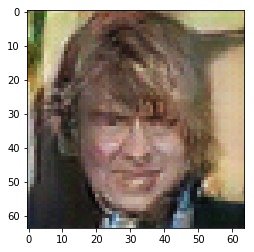





Epoch: [14] [ 936/1761] time: 499267.3936, d_loss: 1.26351535, g_loss: 0.86454558
Epoch: [14] [ 961/1761] time: 499717.5096, d_loss: 1.16141319, g_loss: 0.98707843
Saved model
Epoch: [14] [ 986/1761] time: 500171.1820, d_loss: 1.05795205, g_loss: 1.53380060
Epoch: [14] [1011/1761] time: 500621.9926, d_loss: 1.14535153, g_loss: 1.20420718
Saved model
Sample




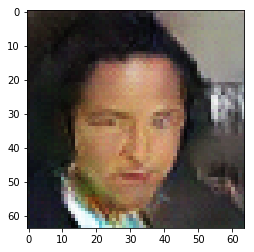





Epoch: [14] [1036/1761] time: 501076.1864, d_loss: 1.51528883, g_loss: 0.45685816
Epoch: [14] [1061/1761] time: 501527.1076, d_loss: 1.42069292, g_loss: 0.61857831
Saved model
Epoch: [14] [1086/1761] time: 501980.8167, d_loss: 2.26127911, g_loss: 0.16527407
Epoch: [14] [1111/1761] time: 502447.8719, d_loss: 2.11469793, g_loss: 0.29259515
Saved model
Sample




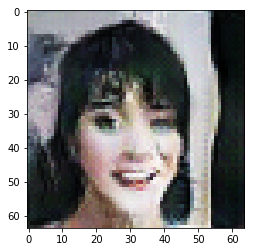





Epoch: [14] [1136/1761] time: 502915.6825, d_loss: 1.20826006, g_loss: 1.22419190
Epoch: [14] [1161/1761] time: 503375.5511, d_loss: 1.34589553, g_loss: 0.60575861
Saved model
Epoch: [14] [1186/1761] time: 503842.3070, d_loss: 1.15841246, g_loss: 0.72739697
Epoch: [14] [1211/1761] time: 504297.1479, d_loss: 1.02731252, g_loss: 0.76604199
Saved model
Sample




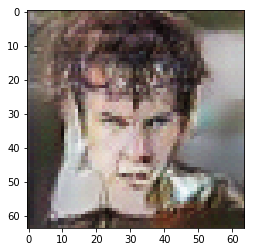





Epoch: [14] [1236/1761] time: 504754.2513, d_loss: 1.36684728, g_loss: 0.60304898
Epoch: [14] [1261/1761] time: 505207.9189, d_loss: 1.48610806, g_loss: 1.13018644
Saved model
Epoch: [14] [1286/1761] time: 505658.8498, d_loss: 1.58917928, g_loss: 0.38866353
Epoch: [14] [1311/1761] time: 506118.8148, d_loss: 1.32963026, g_loss: 0.57611102
Saved model
Sample




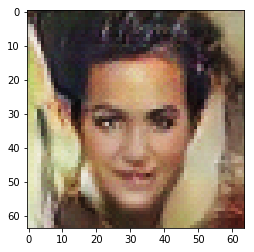





Epoch: [14] [1336/1761] time: 506565.6646, d_loss: 1.35873795, g_loss: 0.84304559
Epoch: [14] [1361/1761] time: 507005.8614, d_loss: 1.25846267, g_loss: 0.93207979
Saved model
Epoch: [14] [1386/1761] time: 507451.5293, d_loss: 1.25354862, g_loss: 0.74919260
Epoch: [14] [1411/1761] time: 507894.0403, d_loss: 1.29566908, g_loss: 1.05006278
Saved model
Sample




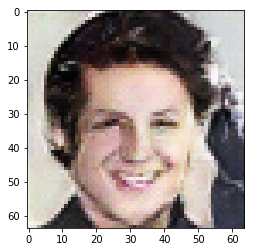





Epoch: [14] [1436/1761] time: 508345.0090, d_loss: 1.25894594, g_loss: 0.70574760
Epoch: [14] [1461/1761] time: 508791.5906, d_loss: 1.33393288, g_loss: 2.19578505
Saved model
Epoch: [14] [1486/1761] time: 509250.2962, d_loss: 1.44721246, g_loss: 2.21324897
Epoch: [14] [1511/1761] time: 509741.2947, d_loss: 1.26673365, g_loss: 0.81947672
Saved model
Sample




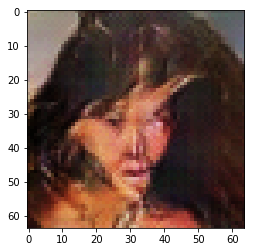





Epoch: [14] [1536/1761] time: 510233.8382, d_loss: 1.35129690, g_loss: 0.57791781
Epoch: [14] [1561/1761] time: 510711.6297, d_loss: 1.04629421, g_loss: 1.00926220
Saved model
Epoch: [14] [1586/1761] time: 511206.4231, d_loss: 1.17960691, g_loss: 1.46400928
Epoch: [14] [1611/1761] time: 511685.3118, d_loss: 1.58273780, g_loss: 0.45811528
Saved model
Sample




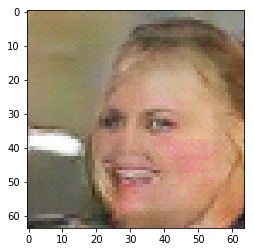





Epoch: [14] [1636/1761] time: 512167.7694, d_loss: 1.27790129, g_loss: 0.61593634
Epoch: [14] [1661/1761] time: 512647.0339, d_loss: 1.30506814, g_loss: 0.65050298
Saved model
Epoch: [14] [1686/1761] time: 513122.4044, d_loss: 1.27487934, g_loss: 0.68326402
Epoch: [14] [1711/1761] time: 513587.1195, d_loss: 1.14035463, g_loss: 0.95430732
Saved model
Sample




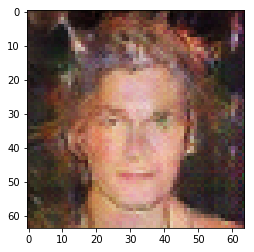





Epoch: [14] [1736/1761] time: 514055.9393, d_loss: 0.85529244, g_loss: 1.35727143
Epoch: [15] [   0/1761] time: 514520.5816, d_loss: 1.54690742, g_loss: 0.46033561
Saved model
Epoch: [15] [  25/1761] time: 514990.4240, d_loss: 1.21715593, g_loss: 0.55432922
Epoch: [15] [  50/1761] time: 515451.0242, d_loss: 1.93443787, g_loss: 0.29269853
Saved model
Sample




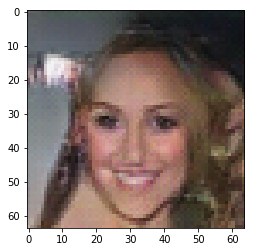





Epoch: [15] [  75/1761] time: 515919.3238, d_loss: 1.45478940, g_loss: 0.51706815
Epoch: [15] [ 100/1761] time: 516395.6398, d_loss: 1.15694165, g_loss: 0.87086284
Saved model
Epoch: [15] [ 125/1761] time: 516899.9625, d_loss: 1.13209724, g_loss: 0.74854022
Epoch: [15] [ 150/1761] time: 517382.9999, d_loss: 1.15675068, g_loss: 0.64917135
Saved model
Sample




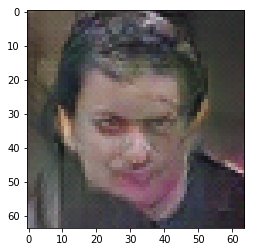





Epoch: [15] [ 175/1761] time: 517883.5396, d_loss: 2.18820643, g_loss: 0.19586655
Epoch: [15] [ 200/1761] time: 518354.3815, d_loss: 1.20508623, g_loss: 0.93450153
Saved model
Epoch: [15] [ 225/1761] time: 518839.0238, d_loss: 1.82408321, g_loss: 0.43402362
Epoch: [15] [ 250/1761] time: 519319.6479, d_loss: 1.42923272, g_loss: 0.41572928
Saved model
Sample




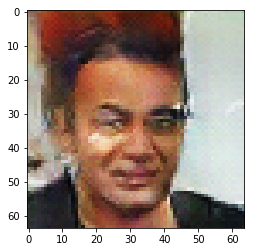





Epoch: [15] [ 275/1761] time: 519804.7945, d_loss: 1.22281241, g_loss: 0.62987781
Epoch: [15] [ 300/1761] time: 520280.3747, d_loss: 1.33061314, g_loss: 0.53353804
Saved model
Epoch: [15] [ 325/1761] time: 520749.9541, d_loss: 1.27512908, g_loss: 0.62441611
Epoch: [15] [ 350/1761] time: 521214.6509, d_loss: 1.38463855, g_loss: 0.67158818
Saved model
Sample




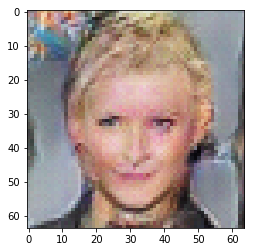





Epoch: [15] [ 375/1761] time: 521684.1349, d_loss: 1.30903196, g_loss: 0.68592227
Epoch: [15] [ 400/1761] time: 522158.0247, d_loss: 1.22225320, g_loss: 0.77790052
Saved model
Epoch: [15] [ 425/1761] time: 522627.8187, d_loss: 1.29355943, g_loss: 0.52414185
Epoch: [15] [ 450/1761] time: 523092.9417, d_loss: 1.72448611, g_loss: 0.43006283
Saved model
Sample




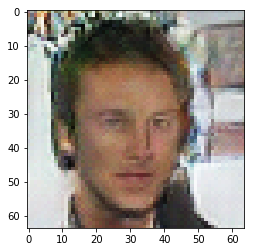





Epoch: [15] [ 475/1761] time: 523565.8173, d_loss: 1.24753737, g_loss: 1.27876270
Epoch: [15] [ 500/1761] time: 524027.6858, d_loss: 1.23936129, g_loss: 1.64411640
Saved model
Epoch: [15] [ 525/1761] time: 524486.2621, d_loss: 1.69559896, g_loss: 0.36524376
Epoch: [15] [ 550/1761] time: 524964.3386, d_loss: 1.96531796, g_loss: 0.26591414
Saved model
Sample




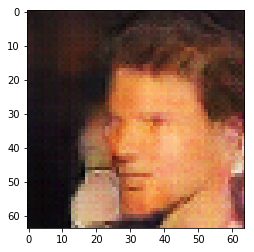





Epoch: [15] [ 575/1761] time: 525459.4972, d_loss: 1.15668011, g_loss: 0.69213229
Epoch: [15] [ 600/1761] time: 525948.8226, d_loss: 1.40736318, g_loss: 0.61658597
Saved model
Epoch: [15] [ 625/1761] time: 526433.9742, d_loss: 1.33680570, g_loss: 1.22477221
Epoch: [15] [ 650/1761] time: 526892.9011, d_loss: 1.10139942, g_loss: 0.76118553
Saved model
Sample




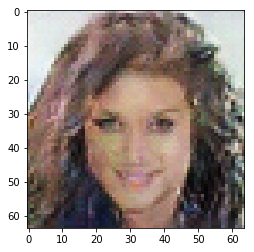





Epoch: [15] [ 675/1761] time: 577553.2349, d_loss: 1.16335702, g_loss: 0.82648718
Epoch: [15] [ 700/1761] time: 578067.6510, d_loss: 1.29089057, g_loss: 0.80731833
Saved model
Epoch: [15] [ 725/1761] time: 578533.9164, d_loss: 1.11271882, g_loss: 0.88380361
Epoch: [15] [ 750/1761] time: 578984.3458, d_loss: 1.11234760, g_loss: 0.87721777
Saved model
Sample




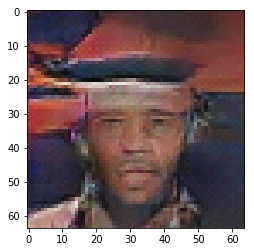





Epoch: [15] [ 775/1761] time: 579439.7536, d_loss: 1.29251480, g_loss: 0.81792569
Epoch: [15] [ 800/1761] time: 579890.1571, d_loss: 1.38552690, g_loss: 0.89721882
Saved model
Epoch: [15] [ 825/1761] time: 580337.7539, d_loss: 1.23220718, g_loss: 0.56436670
Epoch: [15] [ 850/1761] time: 580783.5221, d_loss: 1.18968487, g_loss: 1.29269147
Saved model
Sample




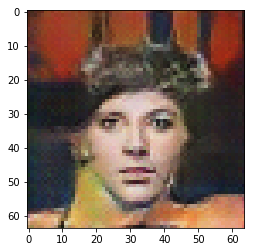





Epoch: [15] [ 875/1761] time: 581241.9944, d_loss: 1.13334632, g_loss: 0.80647206
Epoch: [15] [ 900/1761] time: 581691.7084, d_loss: 1.12932658, g_loss: 0.78219962
Saved model
Epoch: [15] [ 925/1761] time: 582139.9028, d_loss: 1.18826699, g_loss: 0.63024104
Epoch: [15] [ 950/1761] time: 582586.5585, d_loss: 1.00534403, g_loss: 0.92254829
Saved model
Sample




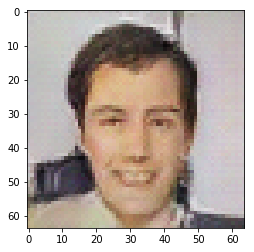





Epoch: [15] [ 975/1761] time: 583037.4160, d_loss: 1.12012649, g_loss: 0.97453088
Epoch: [15] [1000/1761] time: 583503.9942, d_loss: 1.15669513, g_loss: 0.69303232
Saved model
Epoch: [15] [1025/1761] time: 583964.3148, d_loss: 1.34184575, g_loss: 0.56225371
Epoch: [15] [1050/1761] time: 584421.4352, d_loss: 1.07740092, g_loss: 1.00455213
Saved model
Sample




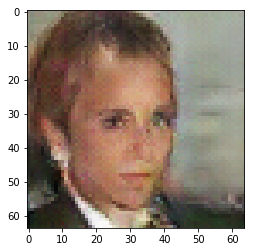





Epoch: [15] [1075/1761] time: 584885.2155, d_loss: 1.71681452, g_loss: 0.37819725
Epoch: [15] [1100/1761] time: 585342.5879, d_loss: 2.30908871, g_loss: 0.16220333
Saved model
Epoch: [15] [1125/1761] time: 585795.4583, d_loss: 2.61644220, g_loss: 0.14373013
Epoch: [15] [1150/1761] time: 586244.8367, d_loss: 1.21815658, g_loss: 0.76352102
Saved model
Sample




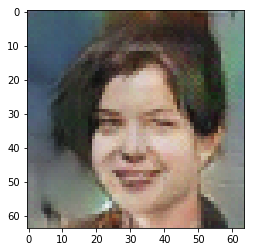





Epoch: [15] [1175/1761] time: 586717.4350, d_loss: 1.65787339, g_loss: 0.43173784
Epoch: [15] [1200/1761] time: 587173.5561, d_loss: 1.25807595, g_loss: 1.36229622
Saved model
Epoch: [15] [1225/1761] time: 587631.8225, d_loss: 1.15720558, g_loss: 1.10635006
Epoch: [15] [1250/1761] time: 588086.6605, d_loss: 1.12682199, g_loss: 1.32028115
Saved model
Sample




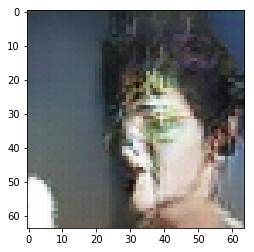





Epoch: [15] [1275/1761] time: 588545.8150, d_loss: 1.27417123, g_loss: 1.15773392
Epoch: [15] [1300/1761] time: 588995.1108, d_loss: 1.23031688, g_loss: 0.83505040
Saved model
Epoch: [15] [1325/1761] time: 589446.4897, d_loss: 1.33528697, g_loss: 0.63392723
Epoch: [15] [1350/1761] time: 589894.5773, d_loss: 1.41438329, g_loss: 1.21656609
Saved model
Sample




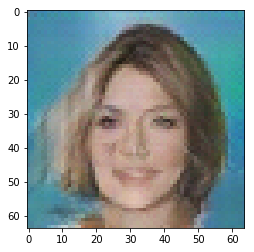





Epoch: [15] [1375/1761] time: 590348.9253, d_loss: 1.01864481, g_loss: 0.89585507
Epoch: [15] [1400/1761] time: 590828.2720, d_loss: 1.45695138, g_loss: 0.55597419
Saved model
Epoch: [15] [1425/1761] time: 591294.1225, d_loss: 1.01751053, g_loss: 1.02043629
Epoch: [15] [1450/1761] time: 591801.3328, d_loss: 1.10330260, g_loss: 0.69229430
Saved model
Sample




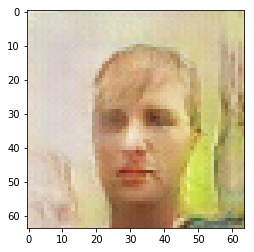





Epoch: [15] [1475/1761] time: 592284.5154, d_loss: 1.20622742, g_loss: 1.43220830
Epoch: [15] [1500/1761] time: 592766.2013, d_loss: 1.07264960, g_loss: 1.14532554
Saved model
Epoch: [15] [1525/1761] time: 593257.6585, d_loss: 0.95003891, g_loss: 1.56266236
Epoch: [15] [1550/1761] time: 593728.2540, d_loss: 1.25109017, g_loss: 0.80753362
Saved model
Sample




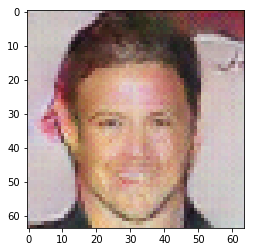





Epoch: [15] [1575/1761] time: 594215.8796, d_loss: 1.24386144, g_loss: 0.76902145
Epoch: [15] [1600/1761] time: 594683.7105, d_loss: 1.26391673, g_loss: 0.56224656
Saved model
Epoch: [15] [1625/1761] time: 595154.4619, d_loss: 1.17405140, g_loss: 0.94229138
Epoch: [15] [1650/1761] time: 595624.9629, d_loss: 1.64121246, g_loss: 0.39224634
Saved model
Sample




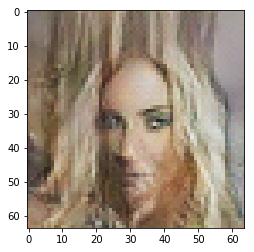





Epoch: [15] [1675/1761] time: 596090.9106, d_loss: 0.94196451, g_loss: 1.23460114
Epoch: [15] [1700/1761] time: 596547.3391, d_loss: 1.20605206, g_loss: 0.99255228
Saved model
Epoch: [15] [1725/1761] time: 597018.7422, d_loss: 1.51035583, g_loss: 0.67621696
Epoch: [15] [1750/1761] time: 597473.9809, d_loss: 1.63432360, g_loss: 0.58913398
Saved model
Sample




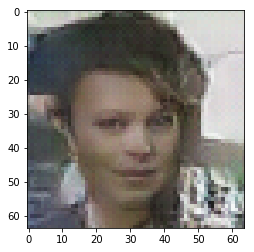





Epoch: [16] [  14/1761] time: 597934.8914, d_loss: 1.14955688, g_loss: 1.52316606
Epoch: [16] [  39/1761] time: 598388.3731, d_loss: 0.70199096, g_loss: 1.23644030
Saved model
Epoch: [16] [  64/1761] time: 598841.1263, d_loss: 1.10315955, g_loss: 0.75235868
Epoch: [16] [  89/1761] time: 599288.1936, d_loss: 1.16820312, g_loss: 0.92779875
Saved model
Sample




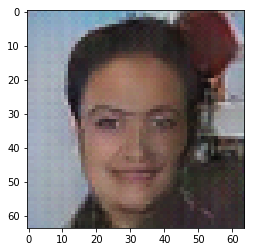





Epoch: [16] [ 114/1761] time: 599740.2368, d_loss: 1.04133308, g_loss: 0.72534060
Epoch: [16] [ 139/1761] time: 600185.8755, d_loss: 1.45643783, g_loss: 0.55995190
Saved model
Epoch: [16] [ 164/1761] time: 600636.9893, d_loss: 0.96232212, g_loss: 0.95455849
Epoch: [16] [ 189/1761] time: 601084.5722, d_loss: 1.14579177, g_loss: 0.76011026
Saved model
Sample




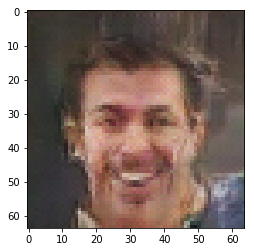





Epoch: [16] [ 214/1761] time: 601538.0811, d_loss: 1.02567172, g_loss: 0.88851082
Epoch: [16] [ 239/1761] time: 601994.9299, d_loss: 1.19586933, g_loss: 0.57774168
Saved model
Epoch: [16] [ 264/1761] time: 602481.5641, d_loss: 1.61158025, g_loss: 0.36482117
Epoch: [16] [ 289/1761] time: 602984.1416, d_loss: 1.22513247, g_loss: 1.17757154
Saved model
Sample




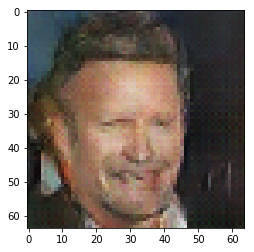





Epoch: [16] [ 314/1761] time: 603516.2231, d_loss: 1.73561001, g_loss: 2.58280134
Epoch: [16] [ 339/1761] time: 603998.0149, d_loss: 1.04810190, g_loss: 1.07558727
Saved model
Epoch: [16] [ 364/1761] time: 604488.7886, d_loss: 1.12334037, g_loss: 0.82126206
Epoch: [16] [ 389/1761] time: 605008.9622, d_loss: 1.30169225, g_loss: 0.81326669
Saved model
Sample




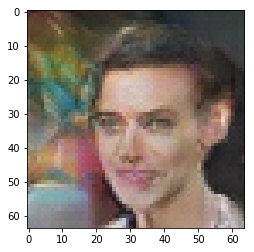

In [ ]:
# use first config to train on CPU, second on GPU
config=tf.ConfigProto(device_count={'GPU': 0})
# config = tf.ConfigProto()

with tf.Session(config=config) as sess:
    train(sess, load_dir=None, save_dir='checkpoint5', show_samples=True, model_name='dcgan1.model', n_generator_update=2)

In [ ]:
# use first config to train on CPU, second on GPU
config=tf.ConfigProto(device_count={'GPU': 0})
# config = tf.ConfigProto()

with tf.Session(config=config) as sess:
    train(sess, load_dir=None, save_dir='checkpoint5', show_samples=True, model_name='dcgan1.model', n_generator_update=3)

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

In [ ]:
# after 3 epochs
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )

for sample in samples[:10]:
    plt.imshow(inverse_transform(sample))
    plt.show()

INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model


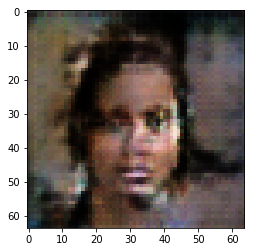

In [15]:
# after 2 epochs
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    
plt.imshow(inverse_transform(samples[10]))

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [47]:
# initialize two random vectors
z1 = np.random.uniform(-1, 1, [1, Z_DIM]).astype(np.float32)
z2 = np.random.uniform(-1, 1, [1, Z_DIM]).astype(np.float32)

# initialize a range of alphas
alphas = np.linspace(0, 1, BATCH_SIZE)

batchz = []

# loop through and create our batch of vectors
for alpha in alphas:
    batchz.append((alpha * z1) + ((1 - alpha) * z2))
    
# convert the list into a numpy array    
batchz = np.squeeze(np.array(batchz))

INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model


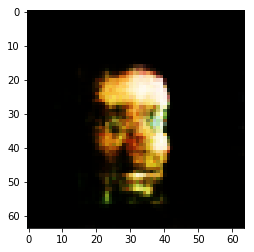

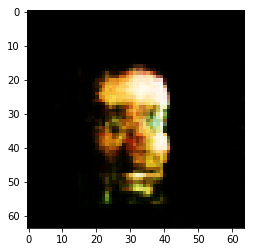

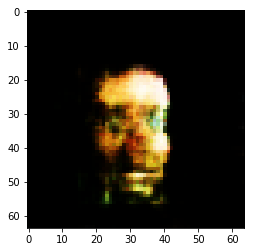

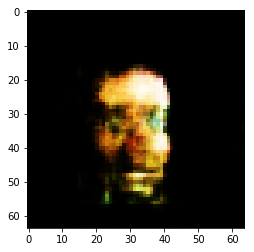

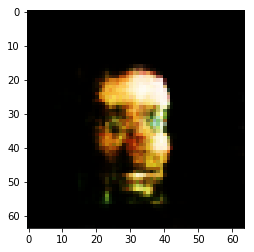

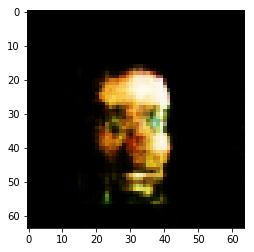

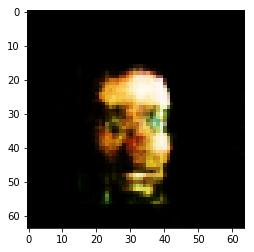

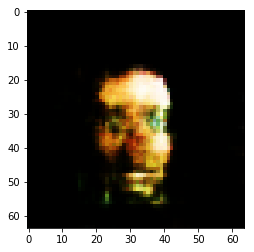

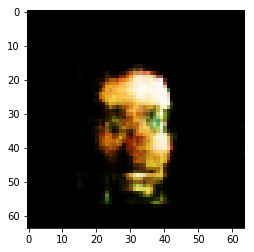

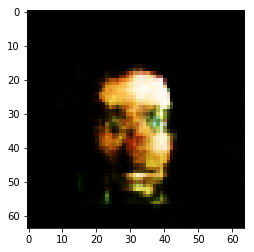

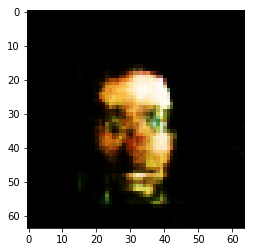

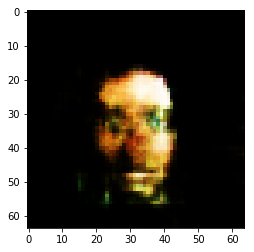

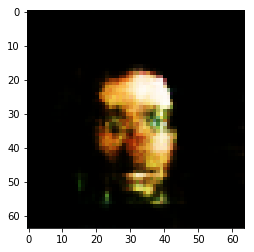

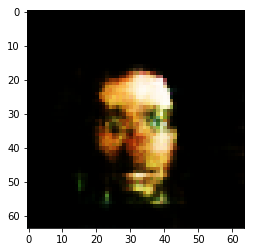

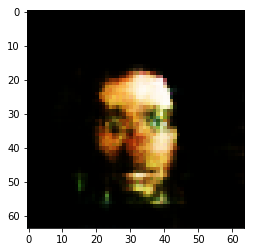

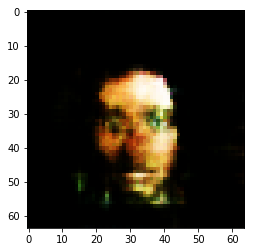

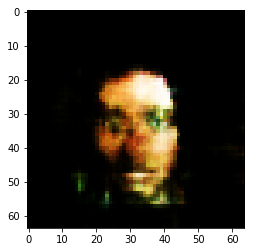

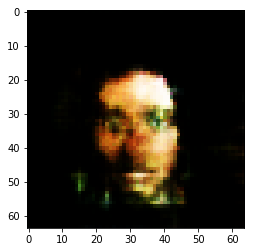

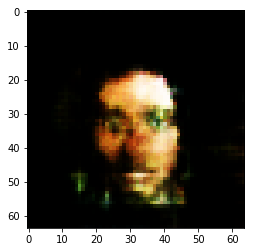

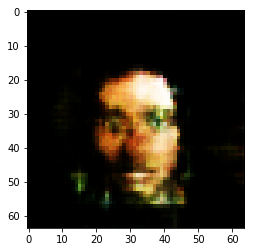

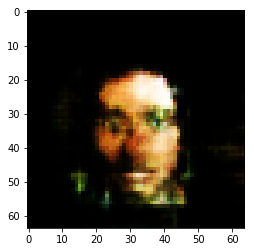

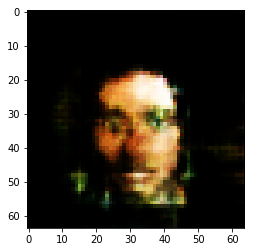

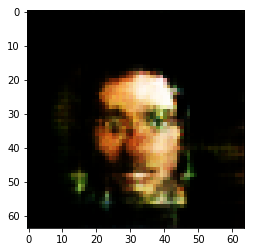

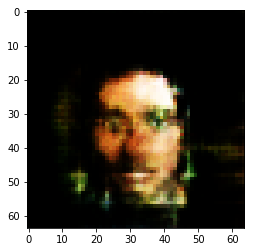

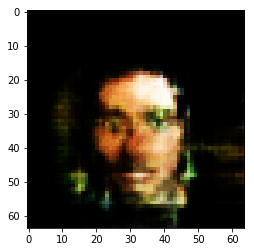

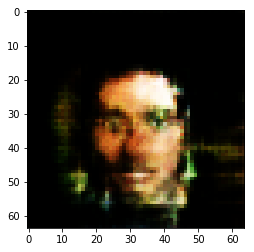

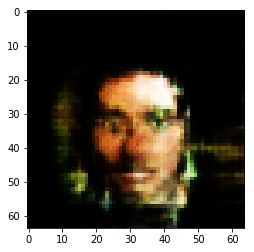

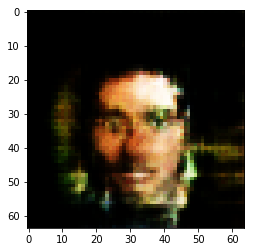

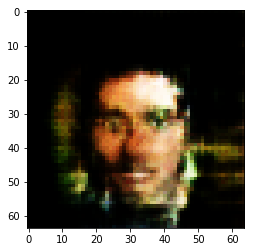

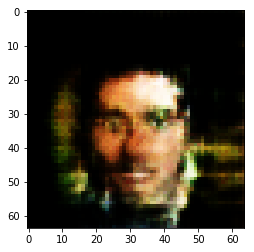

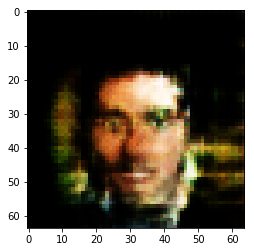

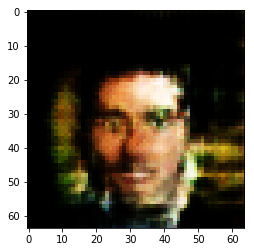

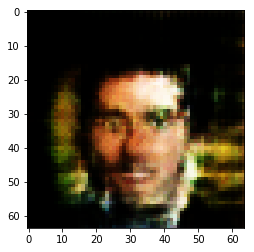

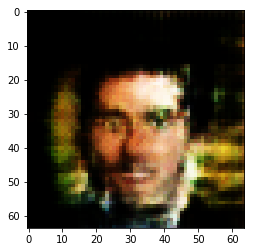

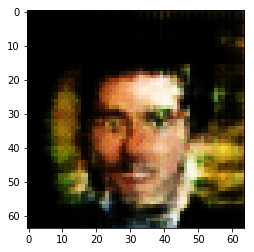

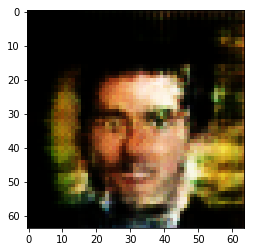

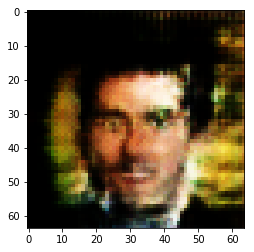

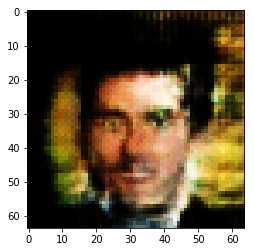

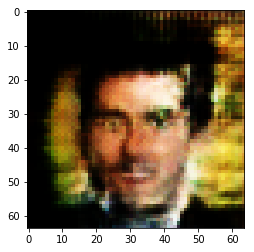

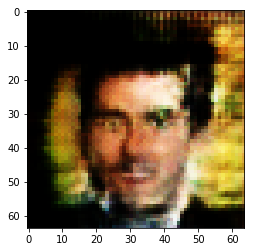

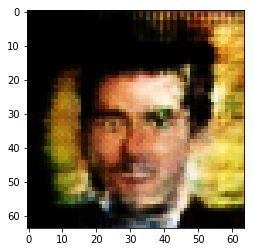

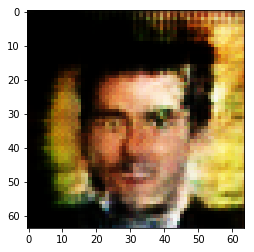

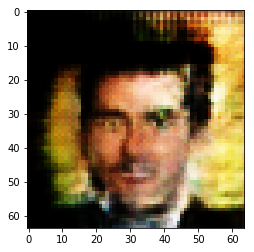

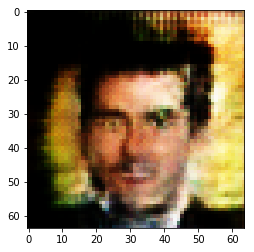

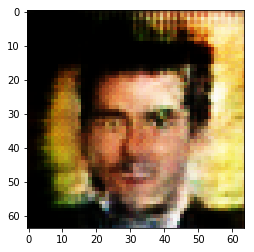

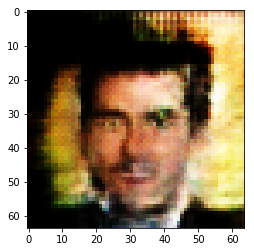

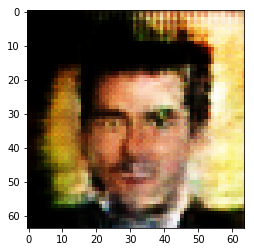

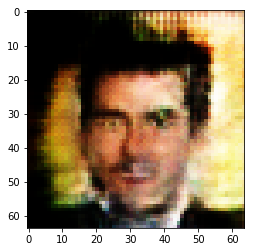

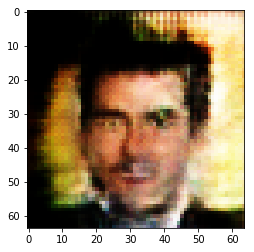

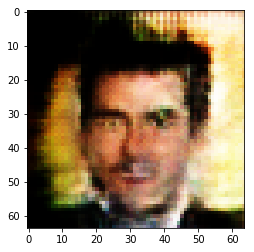

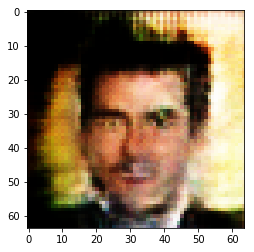

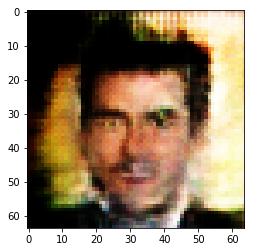

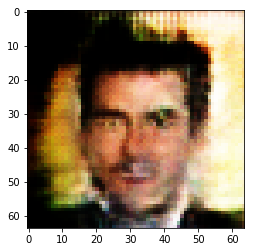

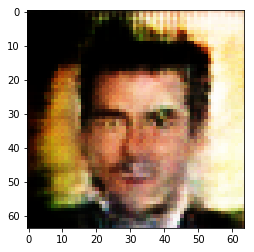

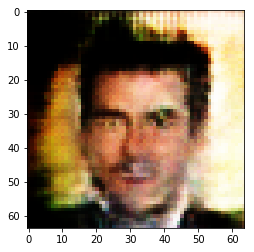

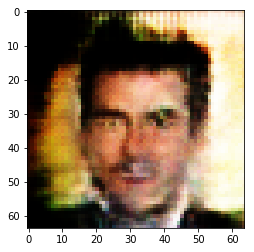

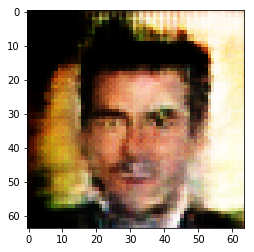

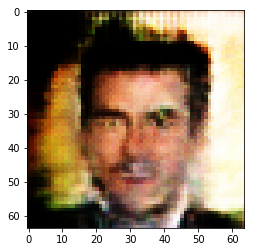

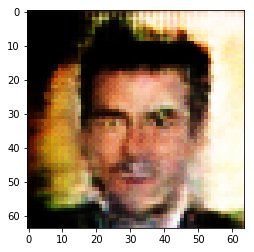

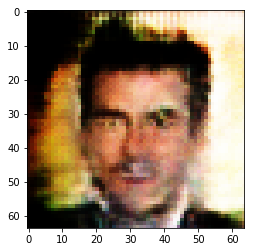

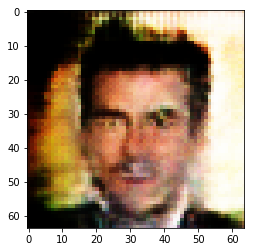

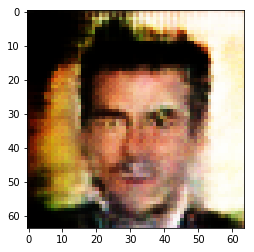

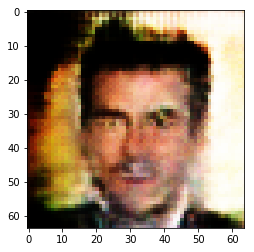

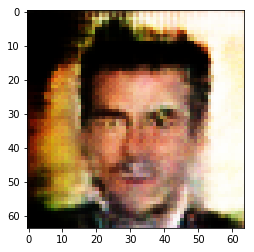

In [48]:
# create images with our vectors as input
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batchz, is_training: False} )
    
# look at the images we created    
for image in samples:
    plt.imshow(inverse_transform(image))
    plt.show()

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

In [25]:
# init lists to add our vectors to
not_smile_vectors = []
smile_vectors = []

In [46]:
# the vectors were added to our list as they were created, seeing which created smiles and which did not
# this lists were created backwards, which is addressed by subtracting the smile vector instead of adding it
not_smile_vectors.append(z1)
smile_vectors.append(z2)

In [61]:
# convert the lists to arrays and squeeze them
not_smile_array = np.squeeze(np.array(not_smile_vectors))
smile_array = np.squeeze(np.array(smile_vectors))

In [62]:
# take the mean of the arrays on axis 0
smile = smile_array.mean(axis=0)
not_smile = not_smile_array.mean(axis=0)

In [67]:
# subtract the not smile from the smile
smile_vector = smile - not_smile

In [71]:
# create some random vectors to test
batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

# I created the initial lists wrong so we subtract the smile vector instead of adding it
smile_batch = batch_z - smile_vector

INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model


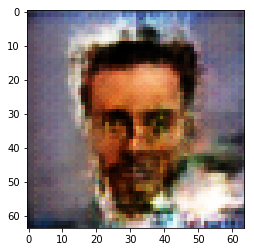

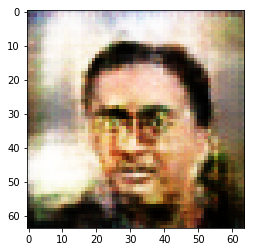

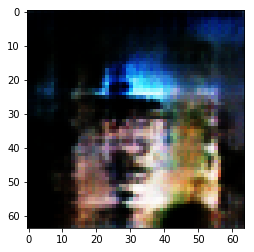

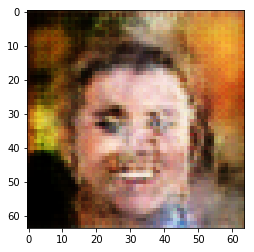

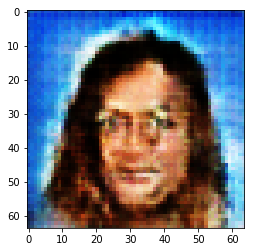

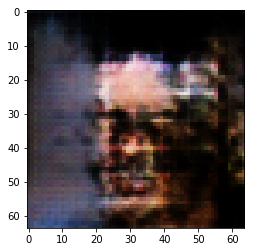

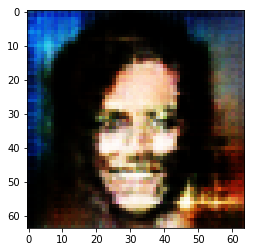

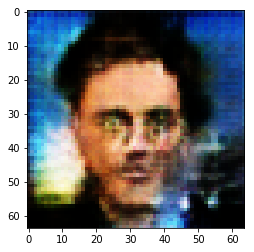

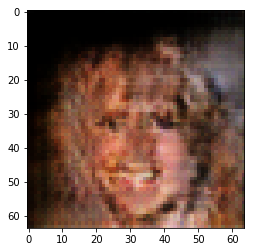

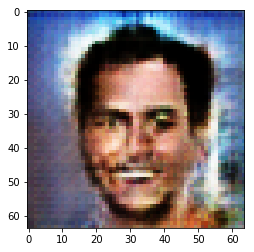

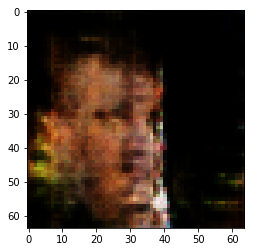

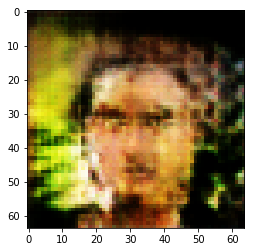

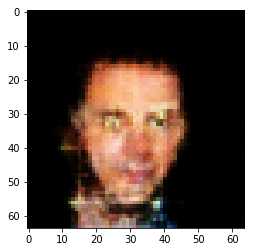

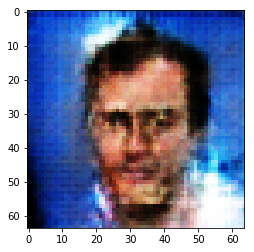

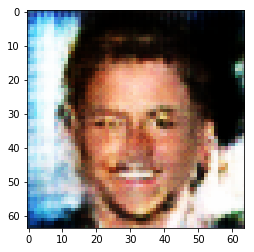

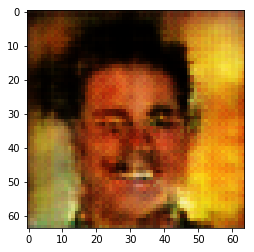

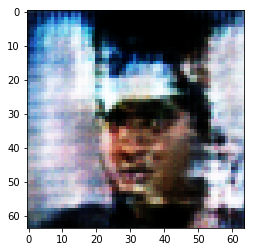

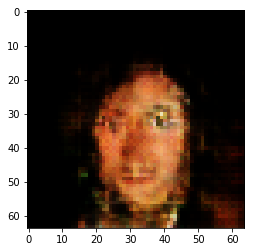

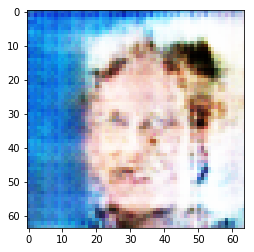

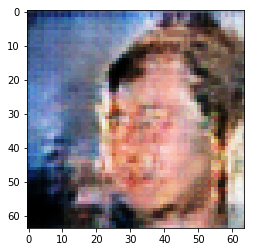

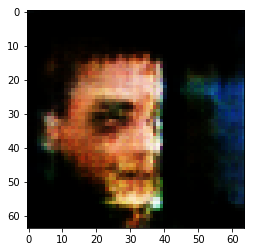

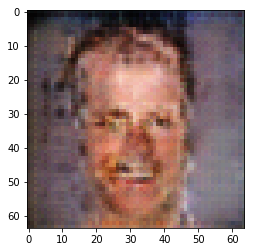

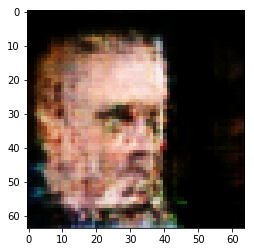

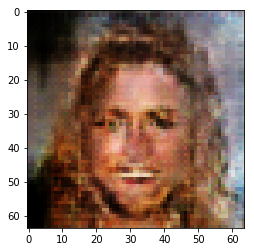

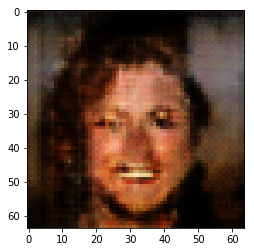

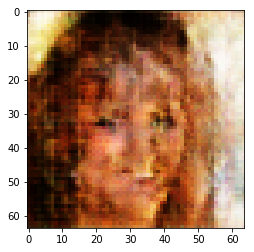

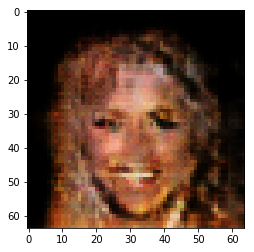

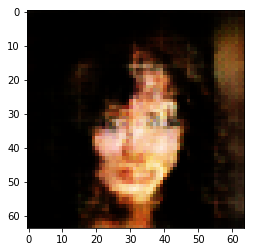

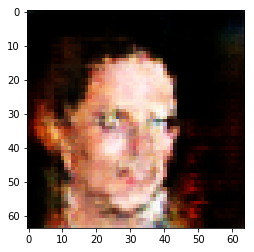

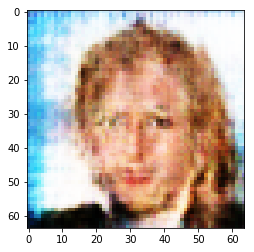

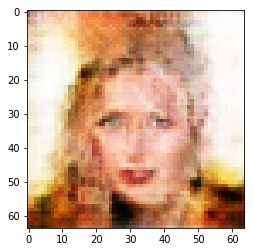

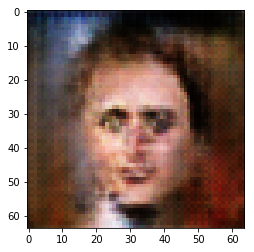

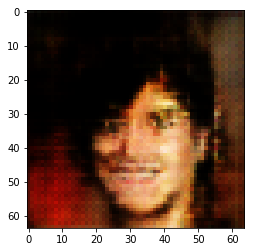

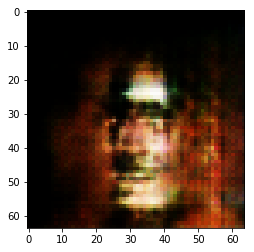

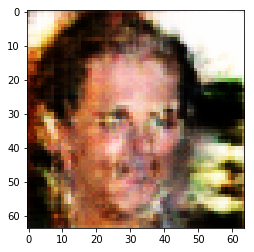

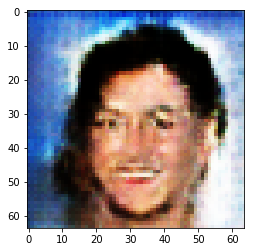

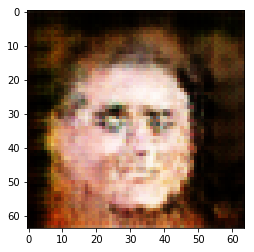

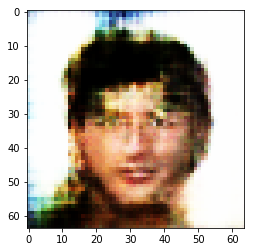

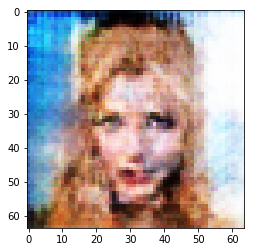

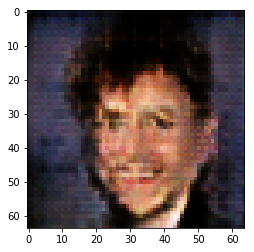

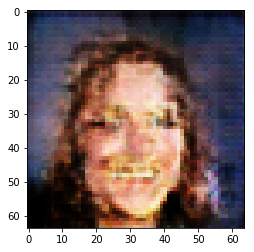

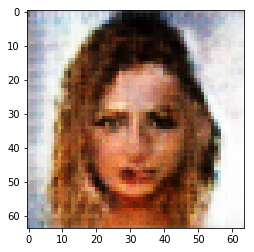

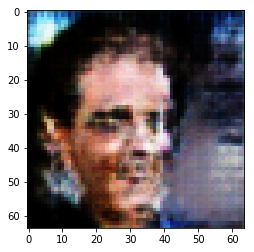

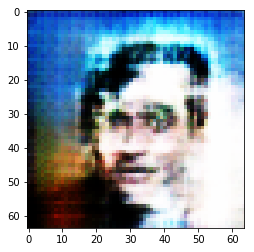

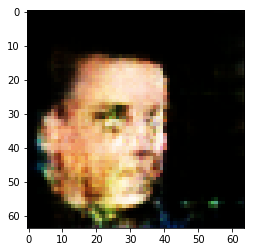

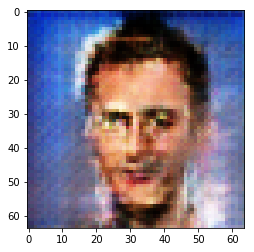

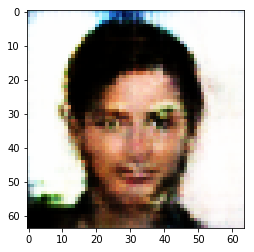

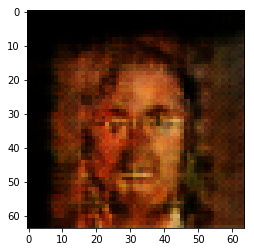

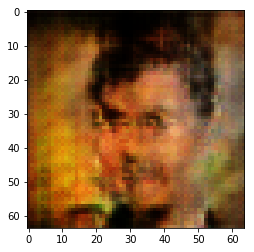

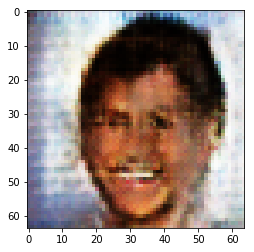

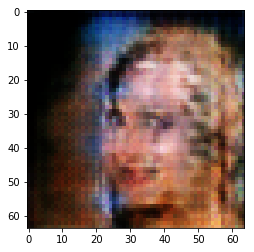

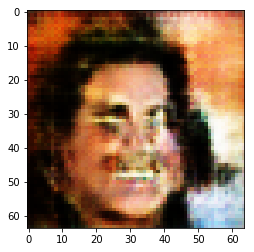

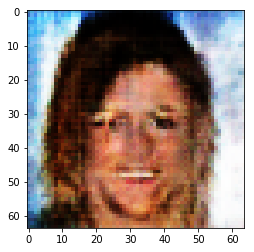

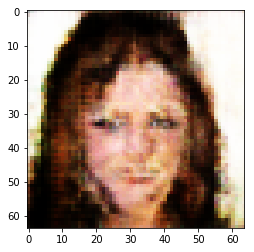

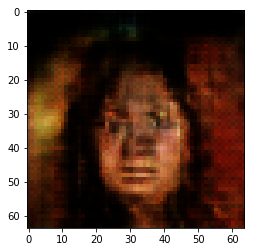

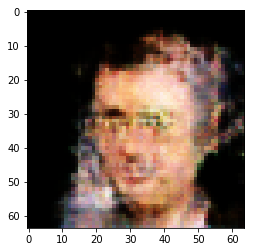

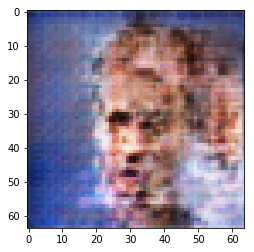

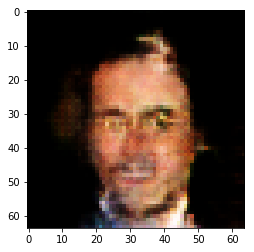

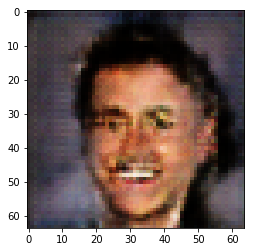

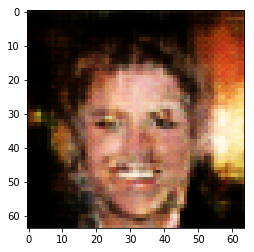

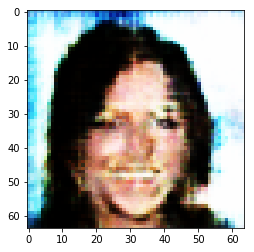

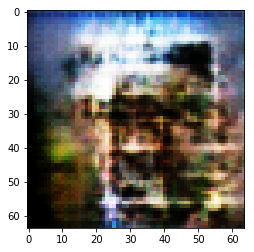

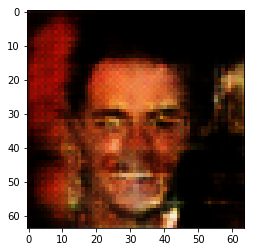

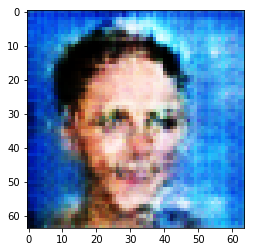

In [72]:
# without smile vector
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
    
# look at the images we created    
for image in samples:
    plt.imshow(inverse_transform(image))
    plt.show()

INFO:tensorflow:Restoring parameters from checkpoint3\dcgan1.model


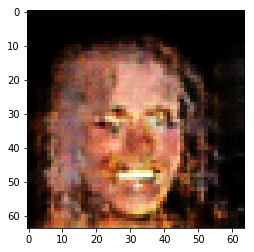

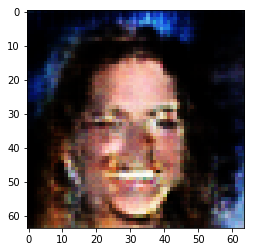

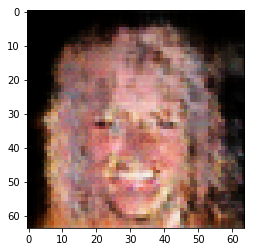

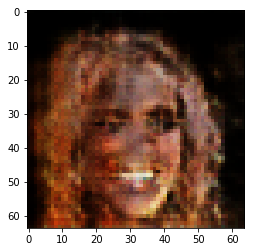

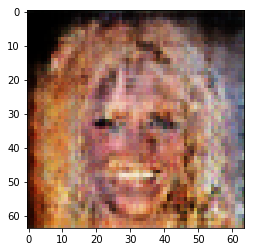

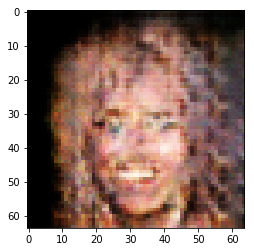

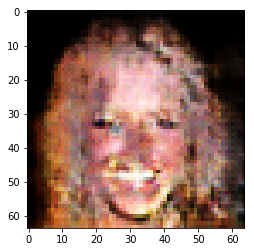

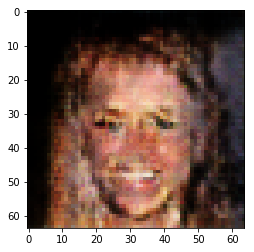

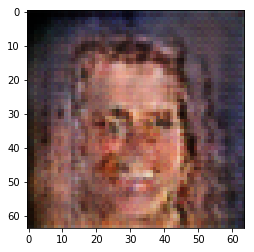

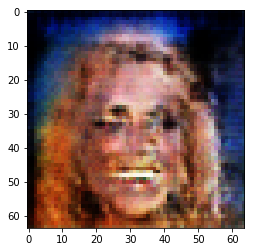

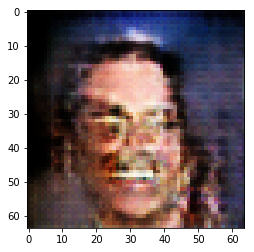

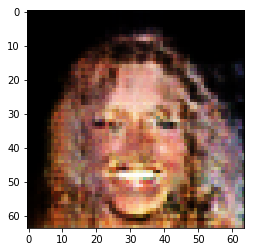

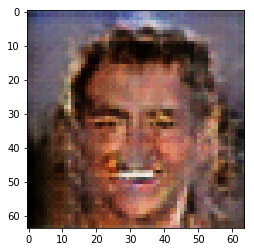

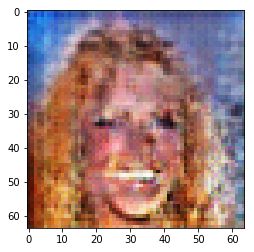

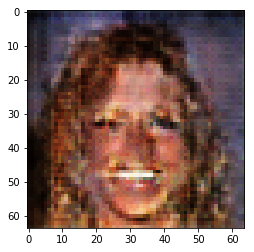

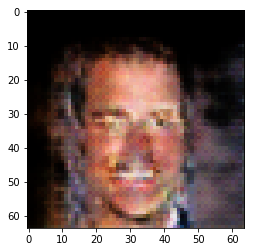

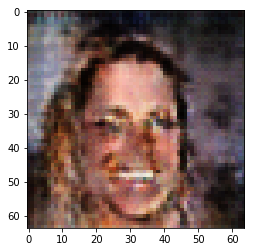

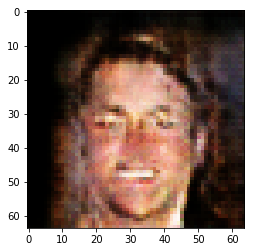

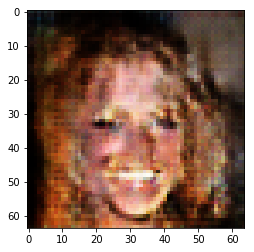

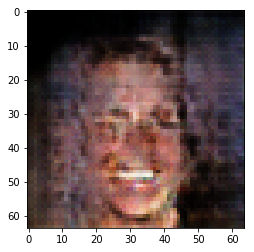

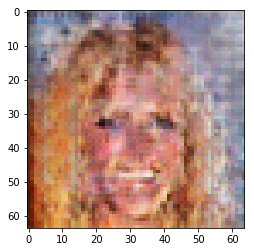

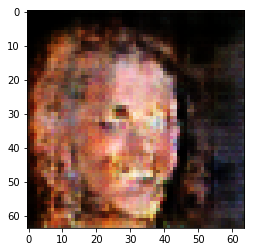

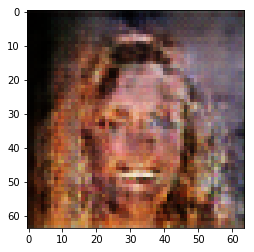

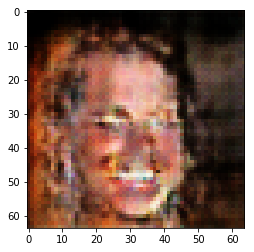

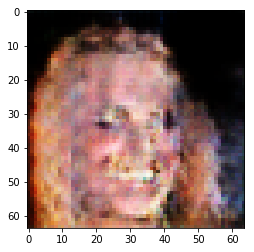

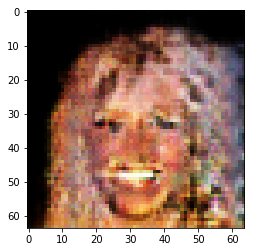

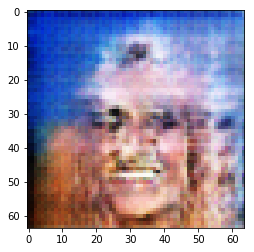

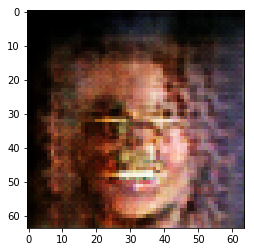

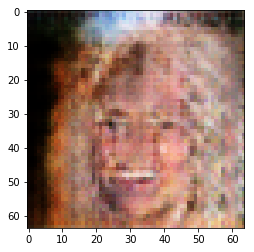

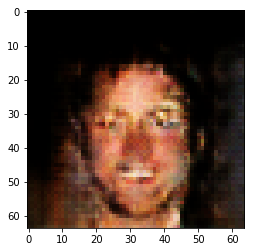

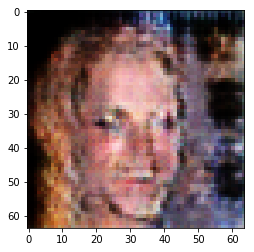

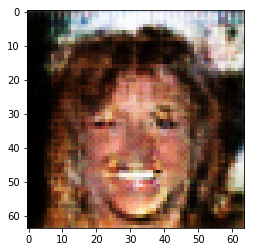

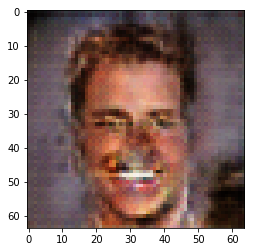

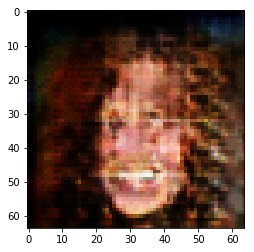

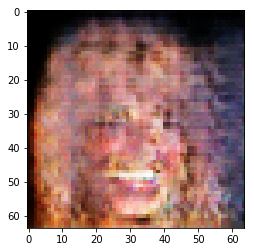

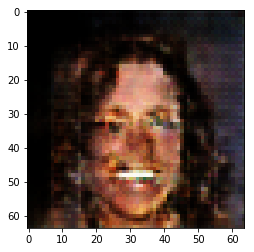

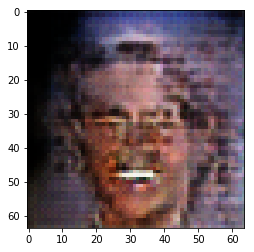

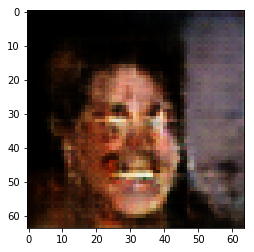

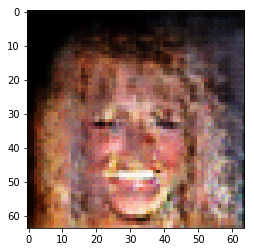

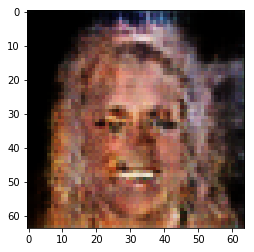

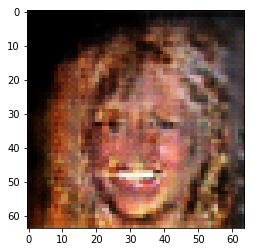

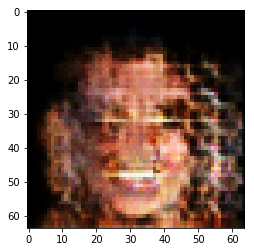

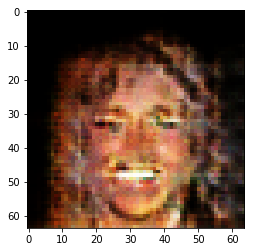

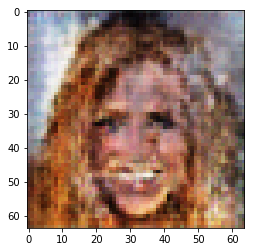

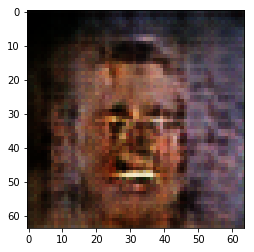

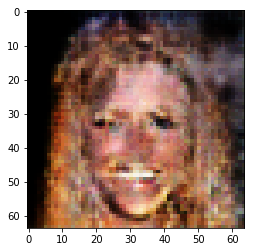

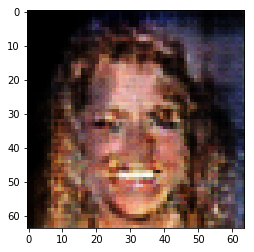

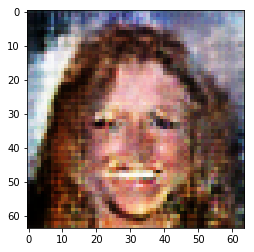

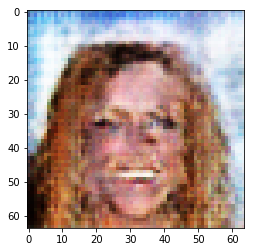

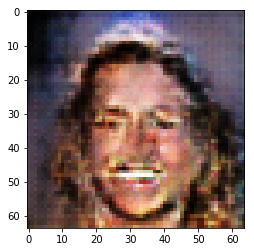

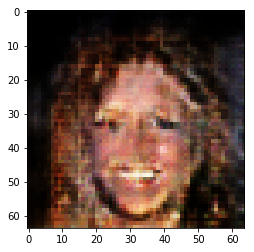

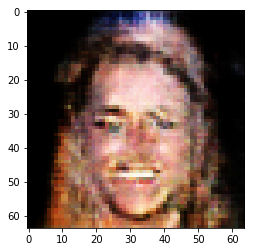

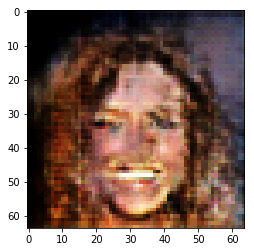

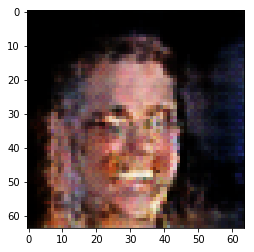

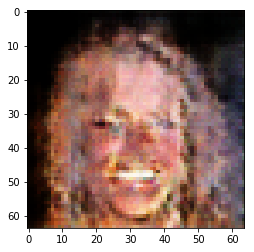

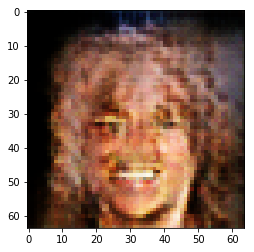

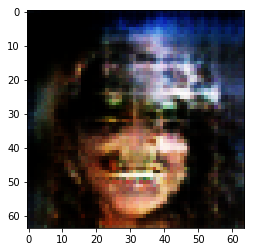

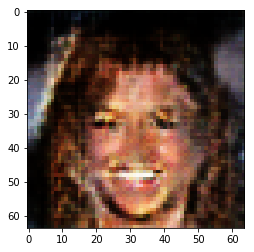

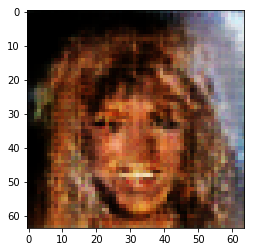

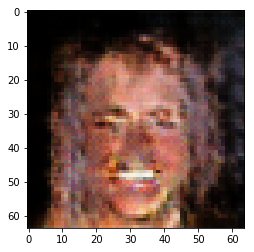

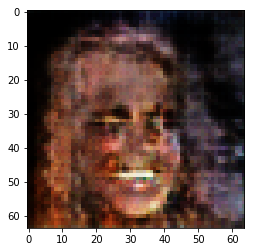

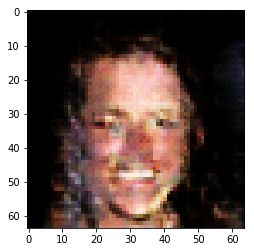

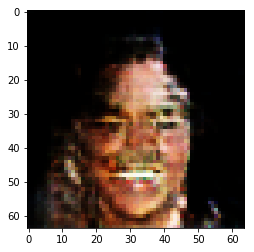

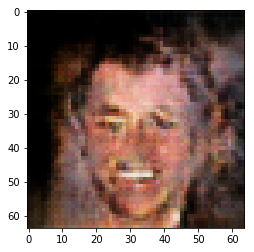

In [73]:
# WITH smile vector
with tf.Session(config=config) as sess:
    load(sess, 'checkpoint3')
    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: smile_batch, is_training: False} )
    
# look at the images we created    
for image in samples:
    plt.imshow(inverse_transform(image))
    plt.show()

If faces looks really cool, add bonus 1 point to your score.